# **T 2.0: IMPORT LIBRARIES**

In [1]:
# Numerical + data
import os, pickle, math, time, warnings
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
print(f"Plotly version: {plotly.__version__}")
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Pre-processing
from sklearn.decomposition import PCA
from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score, GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline

# Models
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score)

# Settings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

Plotly version: 6.5.0


In [2]:
# =============================================================================
# GLOBAL CONFIGURATION
# =============================================================================
# Font and display settings
FONT_TITLE = 24
FONT_AXIS = 20
FONT_TICK = 16
FONT_LEGEND = 16
FONT_ANNOT = 16
DECIMALS = 3
RANDOM_STATE = 0

# Matplotlib settings for figures
plt.rcParams.update({
    'font.size': FONT_TICK,
    'axes.titlesize': FONT_TITLE,
    'axes.titleweight': 'bold',
    'axes.labelsize': FONT_AXIS,
    'axes.labelweight': 'bold',
    'xtick.labelsize': FONT_TICK,
    'ytick.labelsize': FONT_TICK,
    'legend.fontsize': FONT_LEGEND,
    'figure.figsize': (14, 10),
    'figure.dpi': 200
})

# =============================================================================
# GLOBAL HELPER FUNCTIONS
# =============================================================================
def load_or_compute(cache_path, compute_fn, *args, **kwargs):
    """Load cached result or compute and save."""
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            obj = pickle.load(f)
        print(f"[Cache] Loaded from {cache_path}")
        return obj
    obj = compute_fn(*args, **kwargs)
    with open(cache_path, "wb") as f:
        pickle.dump(obj, f)
    print(f"[Cache] Saved to {cache_path}")
    return obj

def fmt(val, decimals=DECIMALS):
    """Format numeric value to specified decimal places."""
    if isinstance(val, (int, np.integer)):
        return val
    return round(float(val), decimals)

def fmt_df(df, decimals=DECIMALS):
    """Return DataFrame with numeric columns rounded."""
    df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].round(decimals)
    return df

def show_df(df, title=None):
    """Display DataFrame with consistent formatting."""
    if title:
        print(f"\n{'='*60}\n{title}\n{'='*60}")
    display(fmt_df(df))

def plotly_layout(fig, title, xlab, ylab, yrange=None, height=600, width=1000):
    fig.update_layout(
        title=dict(text=title, font=dict(size=FONT_TITLE, color="darkblue"), x=0.5),
        xaxis=dict(
            title=dict(text=xlab, font=dict(size=FONT_AXIS, color="darkgreen")),
            tickfont=dict(size=FONT_TICK),
            gridcolor="lightgray",
            showgrid=True
        ),
        yaxis=dict(
            title=dict(text=ylab, font=dict(size=FONT_AXIS, color="darkgreen")),
            tickfont=dict(size=FONT_TICK),
            range=yrange,
            gridcolor="lightgray",
            showgrid=True
        ),
        legend=dict(
            font=dict(size=FONT_LEGEND),
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="gray",
            borderwidth=1
        ),
        plot_bgcolor="white",
        height=height,
        width=width,
        margin=dict(l=80, r=40, t=80, b=80)
    )

def save_plotly_pdf(fig, filename, width=None, height=None):
    """Save Plotly figure as PDF."""
    if width is None:
        width = fig.layout.width if fig.layout.width else 1000
    if height is None:
        height = fig.layout.height if fig.layout.height else 700
    
    fig.write_image(f"{filename}.pdf", format="pdf", width=width, height=height)
    print(f"✓ Saved: {filename}.pdf")

def plot_std_hists_kde(df_std, cols, title, ncols=5, filename=None):
    """Grid of standardized feature histograms with KDE curves."""
    n = len(cols)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
    axes = np.ravel(axes)
    
    for ax, col in zip(axes, cols):
        sns.histplot(df_std[col], bins=20, kde=True, color="royalblue", 
                     alpha=0.85, ax=ax)
        ax.set_title(col, fontsize=12)
        ax.set_xlabel("")
        ax.set_xlim(-1.5, 3)
        ax.tick_params(axis="both", labelsize=10)
    
    for ax in axes[n:]:
        ax.set_visible(False)
    
    fig.suptitle(title, fontsize=FONT_TITLE, fontweight='bold')
    plt.tight_layout(rect=(0, 0, 1, 0.96))
    
    # Save as PDF if filename provided
    if filename:
        plt.savefig(f"{filename}.pdf", format="pdf", bbox_inches="tight", dpi=300)
        print(f"✓ Saved: {filename}.pdf")
    
    plt.show()

# **T 2.1: EXPLORATORY DATA ANALYSIS**

In [3]:
# -----------------------------------------------
# Loading dataset
# -----------------------------------------------
df = pd.read_csv("data-2.csv.gz")
X = df.drop("label", axis=1)
y = df["label"]
n_rows, n_cols = df.shape

print("="*60)
print("DATASET LOADED")
print("="*60)
print(f"Rows: {n_rows}")
print(f"Feature columns: {n_cols - 1} (excluding label)")

# -----------------------------------------------
# Inspecting data: first and last rows
# -----------------------------------------------
print("\n" + "="*60)
print("FIRST 5 ROWS")
print("="*60)
display(df.head(5))

print("\n" + "="*60)
print("LAST 5 ROWS")
print("="*60)
display(df.tail(5))

# -----------------------------------------------
# Summary statistics
# -----------------------------------------------
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
display(fmt_df(df.describe()))

# -----------------------------------------------
# Missing values and zero columns
# -----------------------------------------------
zero_cols = (X == 0).all(axis=0)
n_zero_cols = zero_cols.sum()
zero_col_names = list(X.columns[zero_cols])

print("\n" + "="*60)
print("ZERO-VARIANCE COLUMNS")
print("="*60)
print(f"Columns with all zeros: {n_zero_cols}")
print("\nFirst 10 zero-only columns:")
for i, col in enumerate(zero_col_names[:10], start=1):
    print(f"  {i}: {col}")

# -----------------------------------------------
# Class distribution
# -----------------------------------------------
print("\n" + "="*60)
print("CLASS DISTRIBUTION")
print("="*60)
print(y.value_counts())

y_counts = y.value_counts().sort_index()
y_pct = y_counts / y_counts.sum() * 100
labels = ["Left (0)", "Right (1)"]
colors = ["#57C6CA", "#26389C"]

fig_class = go.Figure()
fig_class.add_trace(go.Bar(
    x=labels, y=y_pct.values,
    marker=dict(color=colors),
    text=[f"{v:.1f}%" for v in y_pct.values],
    textposition="outside",
    textfont=dict(size=FONT_ANNOT),
    hovertemplate="Class: %{x}<br>Percentage: %{y:.1f}%<extra></extra>"
))
plotly_layout(fig_class, "Label Distribution: Left vs Right", 
              "", "Percentage (%)", [0, 100], width=700, height=500)
fig_class.show()
save_plotly_pdf(fig_class, "class", 700, 500)

DATASET LOADED
Rows: 683
Feature columns: 11190 (excluding label)

FIRST 5 ROWS


label  unit_0000_bin_0  unit_0001_bin_0  unit_0002_bin_0  unit_0003_bin_0  \
0      1                1                0                0                2   
1      0                4                8                0                3   
2      1                2                5                0                2   
3      0                0                8                0                0   
4      0                0                2                1                3   

   unit_0004_bin_0  unit_0005_bin_0  unit_0006_bin_0  unit_0007_bin_0  \
0                6                0                0                1   
1                9               13                6                3   
2                7                1                0                0   
3                6                0                0                1   
4                9                0                0                0   

   unit_0008_bin_0  unit_0009_bin_0  unit_0010_bin_0  unit_0011_bin_0  \
0                0                2                0                4   
1                0                1                0                3   
2                0                0                1                2   
3                0                0                2                1   
4                0                0                1                1   

   unit_0012_bin_0  unit_0013_bin_0  unit_0014_bin_0  unit_0015_bin_0  \
0                0                1                0                1   
1                0                3                0                4   
2                0                1                0                4   
3                0                1                0                0   
4                0                1                0                3   

   unit_0016_bin_0  unit_0017_bin_0  unit_0018_bin_0  unit_0019_bin_0  \
0                0                0                0                0   
1                3                0                0                4   
2                4                0                0                2   
3                7                0                0                4   
4                2                0                0                0   

   unit_0020_bin_0  unit_0021_bin_0  unit_0022_bin_0  unit_0023_bin_0  \
0                0                0                0                1   
1                0                0                3                7   
2                0                0                0                2   
3                2                0                0                3   
4                0                0                0                0   

   unit_0024_bin_0  unit_0025_bin_0  unit_0026_bin_0  unit_0027_bin_0  \
0                0                0                1                0   
1                0                0                1                0   
2                1                0                0                0   
3                0                1                0                0   
4                0                0                0                0   

   unit_0028_bin_0  unit_0029_bin_0  unit_0030_bin_0  unit_0031_bin_0  \
0                2                1                1                0   
1               11                2                1                0   
2                4                2                4                0   
3                3                3                4                3   
4                2                2                4                0   

   unit_0032_bin_0  unit_0033_bin_0  unit_0034_bin_0  unit_0035_bin_0  \
0                0                0                0                0   
1                3                0                1                0   
2                3                1                0                1   
3                2                0                0                0   
4                0                0                0                0   

   unit_00


LAST 5 ROWS


label  unit_0000_bin_0  unit_0001_bin_0  unit_0002_bin_0  \
678      0                0                2                0   
679      0                0                0                0   
680      0                0                0                0   
681      0                0                0                0   
682      0                0                0                0   

     unit_0003_bin_0  unit_0004_bin_0  unit_0005_bin_0  unit_0006_bin_0  \
678                1                0                1                1   
679                6                0                0                0   
680                0                0                0                0   
681                1                0                0                0   
682                6                0                0                2   

     unit_0007_bin_0  unit_0008_bin_0  unit_0009_bin_0  unit_0010_bin_0  \
678                0                0                2                1   
679                4                0                2                1   
680                0                0                0                0   
681                0                0                1                0   
682                0                0                2                3   

     unit_0011_bin_0  unit_0012_bin_0  unit_0013_bin_0  unit_0014_bin_0  \
678                1                0                2                0   
679                0                0                0                0   
680                0                0                0                0   
681                0                0                0                0   
682                0                0                0                0   

     unit_0015_bin_0  unit_0016_bin_0  unit_0017_bin_0  unit_0018_bin_0  \
678                3                1                0                0   
679                1                0                0                0   
680                1                1                0                0   
681                2                1                0                0   
682                1                0                1                0   

     unit_0019_bin_0  unit_0020_bin_0  unit_0021_bin_0  unit_0022_bin_0  \
678                0                2                0                3   
679                0                2                0                3   
680                0                1                0                5   
681                0                2                0                0   
682                1                0                0                0   

     unit_0023_bin_0  unit_0024_bin_0  unit_0025_bin_0  unit_0026_bin_0  \
678                5                2                1                1   
679                2                0                3                0   
680                1                1                2                1   
681                2                2                0                1   
682                0                0                2                0   

     unit_0027_bin_0  unit_0028_bin_0  unit_0029_bin_0  unit_0030_bin_0  \
678                0                3                0                0   
679                0                0                1                3   
680                0                2                0                1   
681                0                0                0                0   
682                0                0                0                1   

     unit_0031_bin_0  unit_0032_bin_0  unit_0033_bin_0  unit_0034_bin_0  \
678                1                2                0                0   
679                1                2                0                0   
680                2                3                0                0   
681                1                3                0                0   
682                2                2                0                0   

     u


SUMMARY STATISTICS


label  unit_0000_bin_0  unit_0001_bin_0  unit_0002_bin_0  \
count  683.000          683.000          683.000          683.000   
mean     0.695            1.512            2.991            0.237   
std      0.461            1.368            1.936            0.661   
min      0.000            0.000            0.000            0.000   
25%      0.000            0.000            2.000            0.000   
50%      1.000            1.000            3.000            0.000   
75%      1.000            2.000            4.000            0.000   
max      1.000            7.000           10.000            5.000   

       unit_0003_bin_0  unit_0004_bin_0  unit_0005_bin_0  unit_0006_bin_0  \
count          683.000          683.000          683.000          683.000   
mean             0.757            1.287            1.447            0.931   
std              1.239            2.622            3.199            1.541   
min              0.000            0.000            0.000            0.000   
25%              0.000            0.000            0.000            0.000   
50%              0.000            0.000            0.000            0.000   
75%              1.000            1.000            1.000            1.000   
max              9.000           15.000           19.000            9.000   

       unit_0007_bin_0  unit_0008_bin_0  unit_0009_bin_0  unit_0010_bin_0  \
count          683.000            683.0          683.000          683.000   
mean             1.070              0.0            1.048            0.621   
std              1.505              0.0            1.243            0.857   
min              0.000              0.0            0.000            0.000   
25%              0.000              0.0            0.000            0.000   
50%              1.000              0.0            1.000            0.000   
75%              2.000              0.0            2.000            1.000   
max             11.000              0.0            7.000            5.000   

       unit_0011_bin_0  unit_0012_bin_0  unit_0013_bin_0  unit_0014_bin_0  \
count          683.000          683.000          683.000            683.0   
mean             2.303            0.193            0.561              0.0   
std              1.477            0.479            0.772              0.0   
min              0.000            0.000            0.000              0.0   
25%              1.000            0.000            0.000              0.0   
50%              2.000            0.000            0.000              0.0   
75%              3.000            0.000            1.000              0.0   
max              8.000            3.000            4.000              0.0   

       unit_0015_bin_0  unit_0016_bin_0  unit_0017_bin_0  unit_0018_bin_0  \
count          683.000          683.000          683.000          683.000   
mean             1.445            1.606            0.041            0.015   
std              1.235            1.711            0.206            0.120   
min              0.000            0.000            0.000            0.000   
25%              1.000            0.000            0.000            0.000   
50%              1.000            1.000            0.000            0.000   
75%              2.000            3.000            0.000            0.000   
max              6.000            9.000            2.000            1.000   

       unit_0019_bin_0  unit_0020_bin_0  unit_0021_bin_0  unit_0022_bin_0  \
count          683.000          683.000          683.000          683.000   
mean             0.966            1.827            0.023            1.852   
std              1.420            1.965            0.151            1.982   
min              0.000            0.000            0.000            0.000   
25%              0.000            0.000            0.000            0.000   
50%              0.000            1.000            0.000            1.000   
75%              2.000            3.000            0.000            3.00


ZERO-VARIANCE COLUMNS
Columns with all zeros: 536

First 10 zero-only columns:
  1: unit_0008_bin_0
  2: unit_0014_bin_0
  3: unit_0050_bin_0
  4: unit_0060_bin_0
  5: unit_0130_bin_0
  6: unit_0153_bin_0
  7: unit_0205_bin_0
  8: unit_0255_bin_0
  9: unit_0325_bin_0
  10: unit_0368_bin_0

CLASS DISTRIBUTION
label
1    475
0    208
Name: count, dtype: int64


✓ Saved: class.pdf



FEATURE DISTRIBUTIONS (STANDARDIZED)
✓ Saved: hist_kde_first.pdf


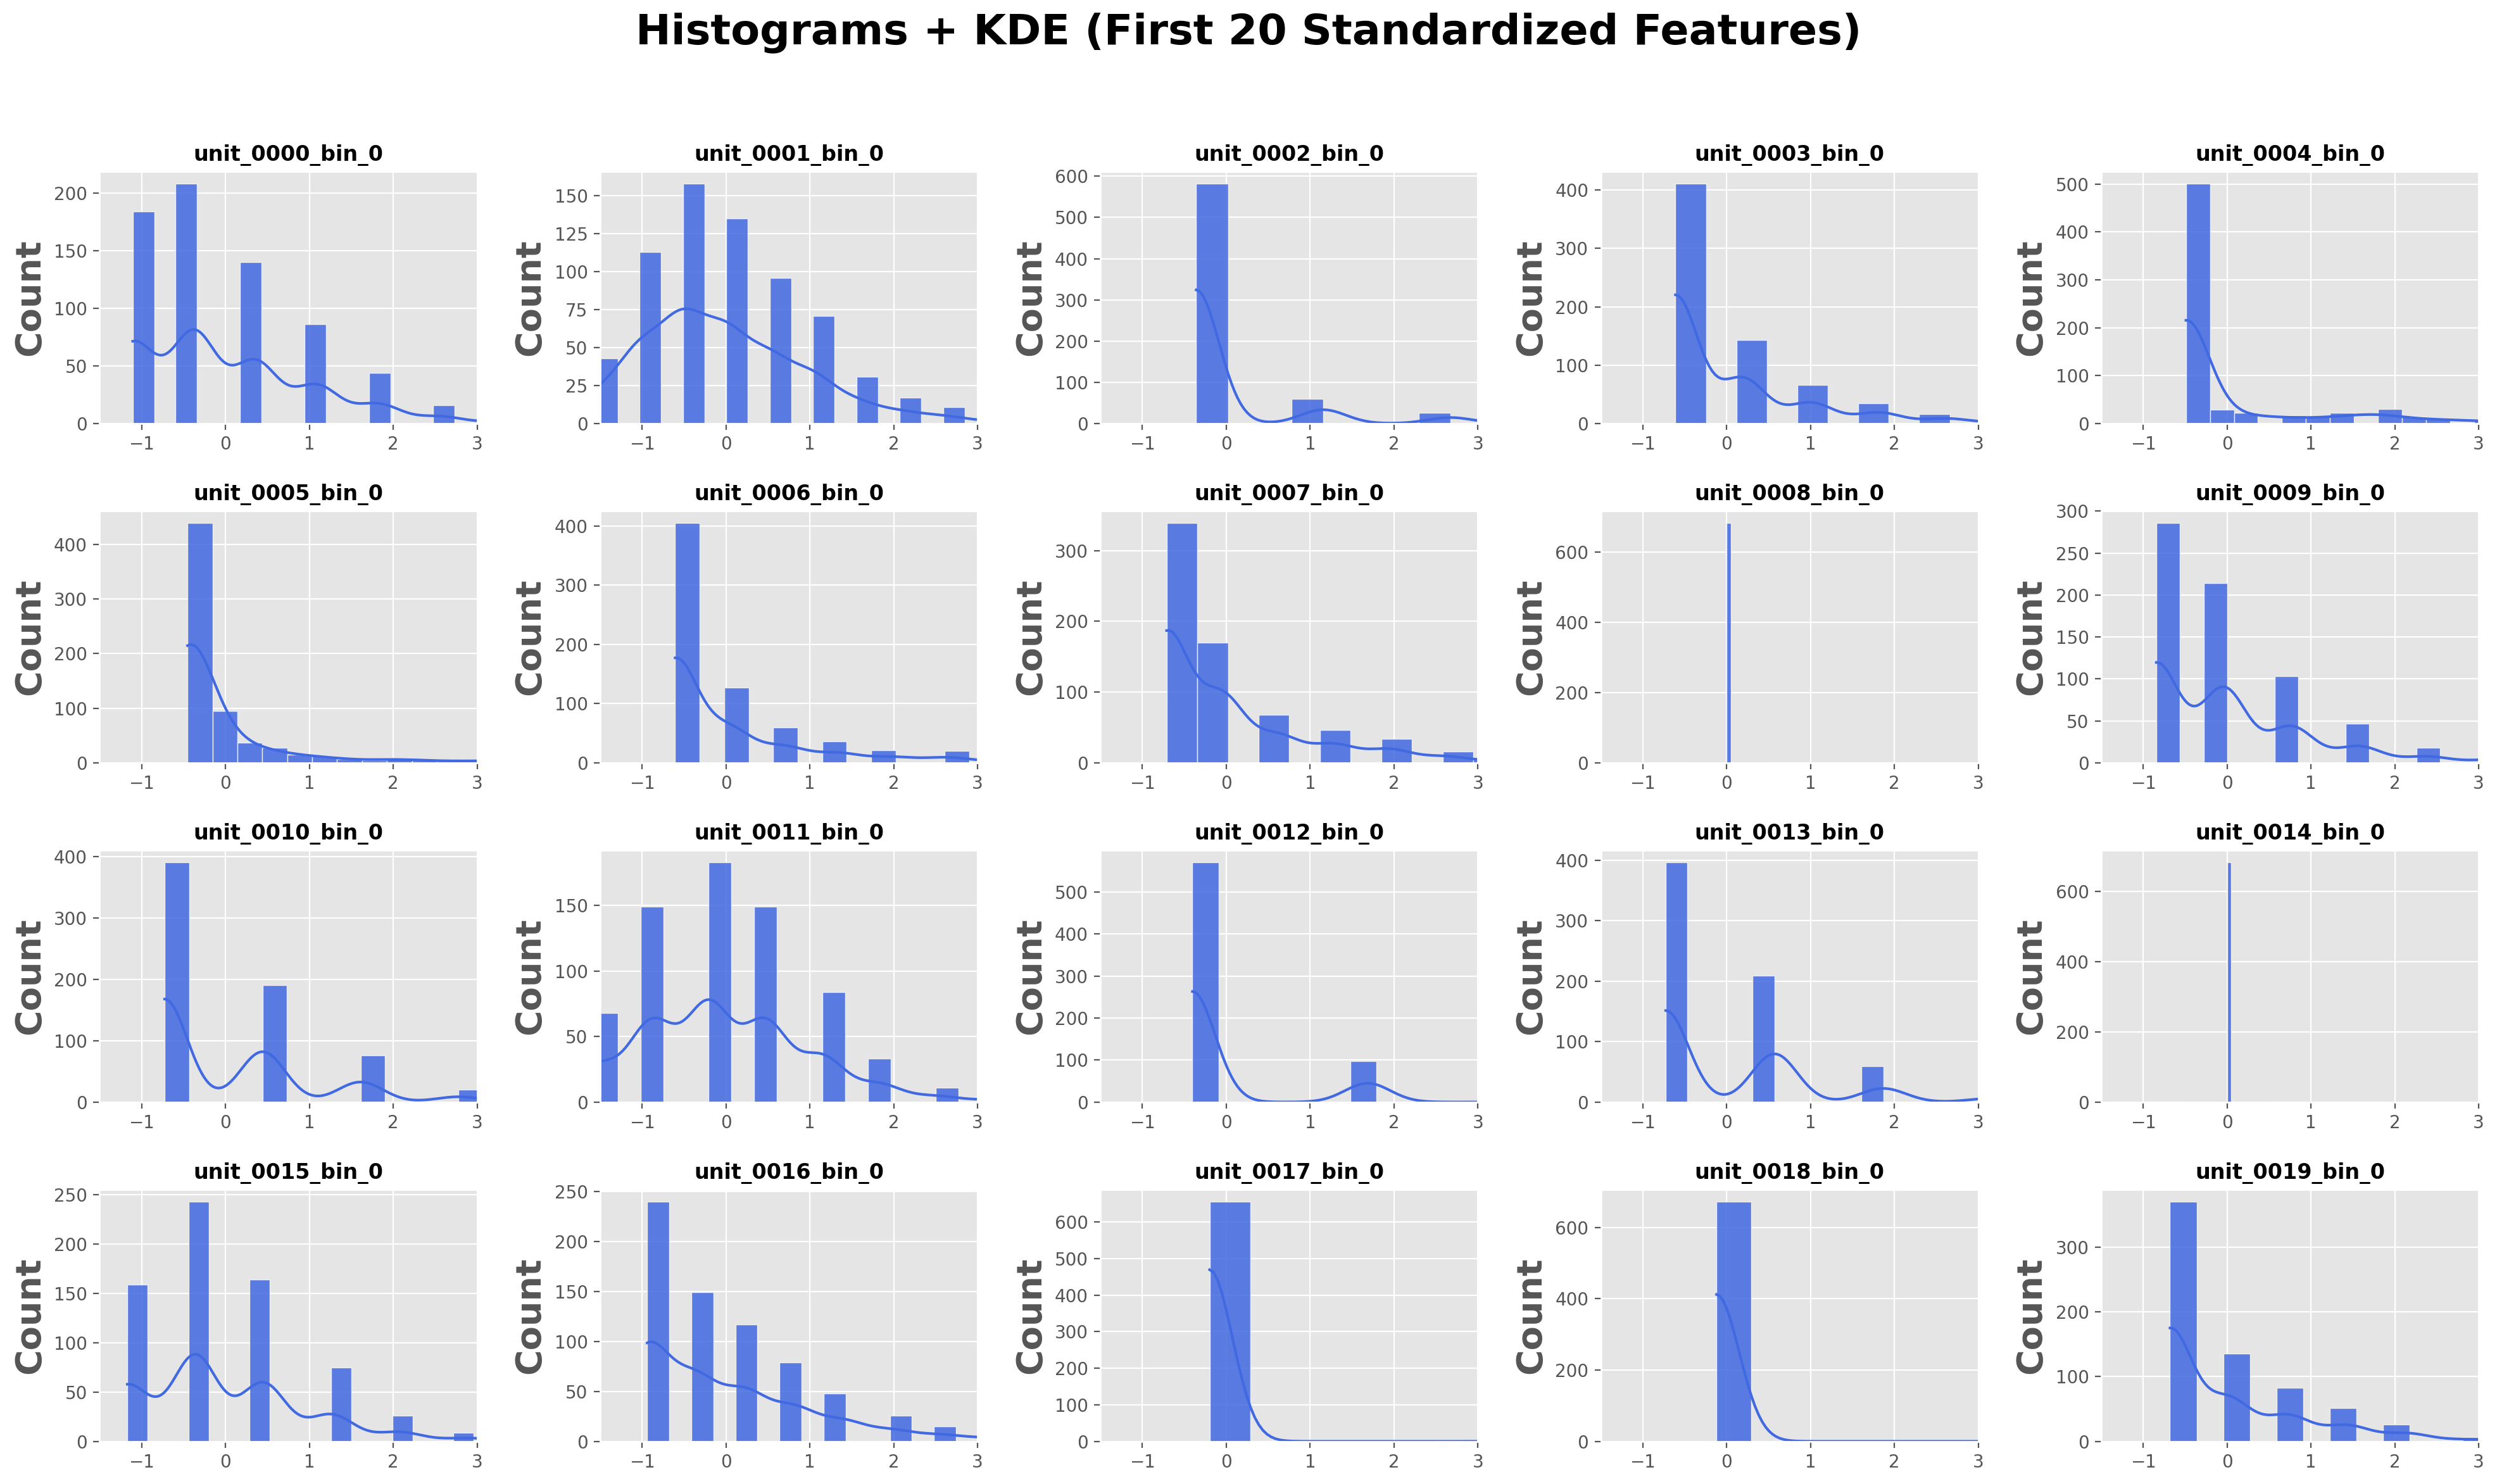

✓ Saved: hist_kde_last.pdf


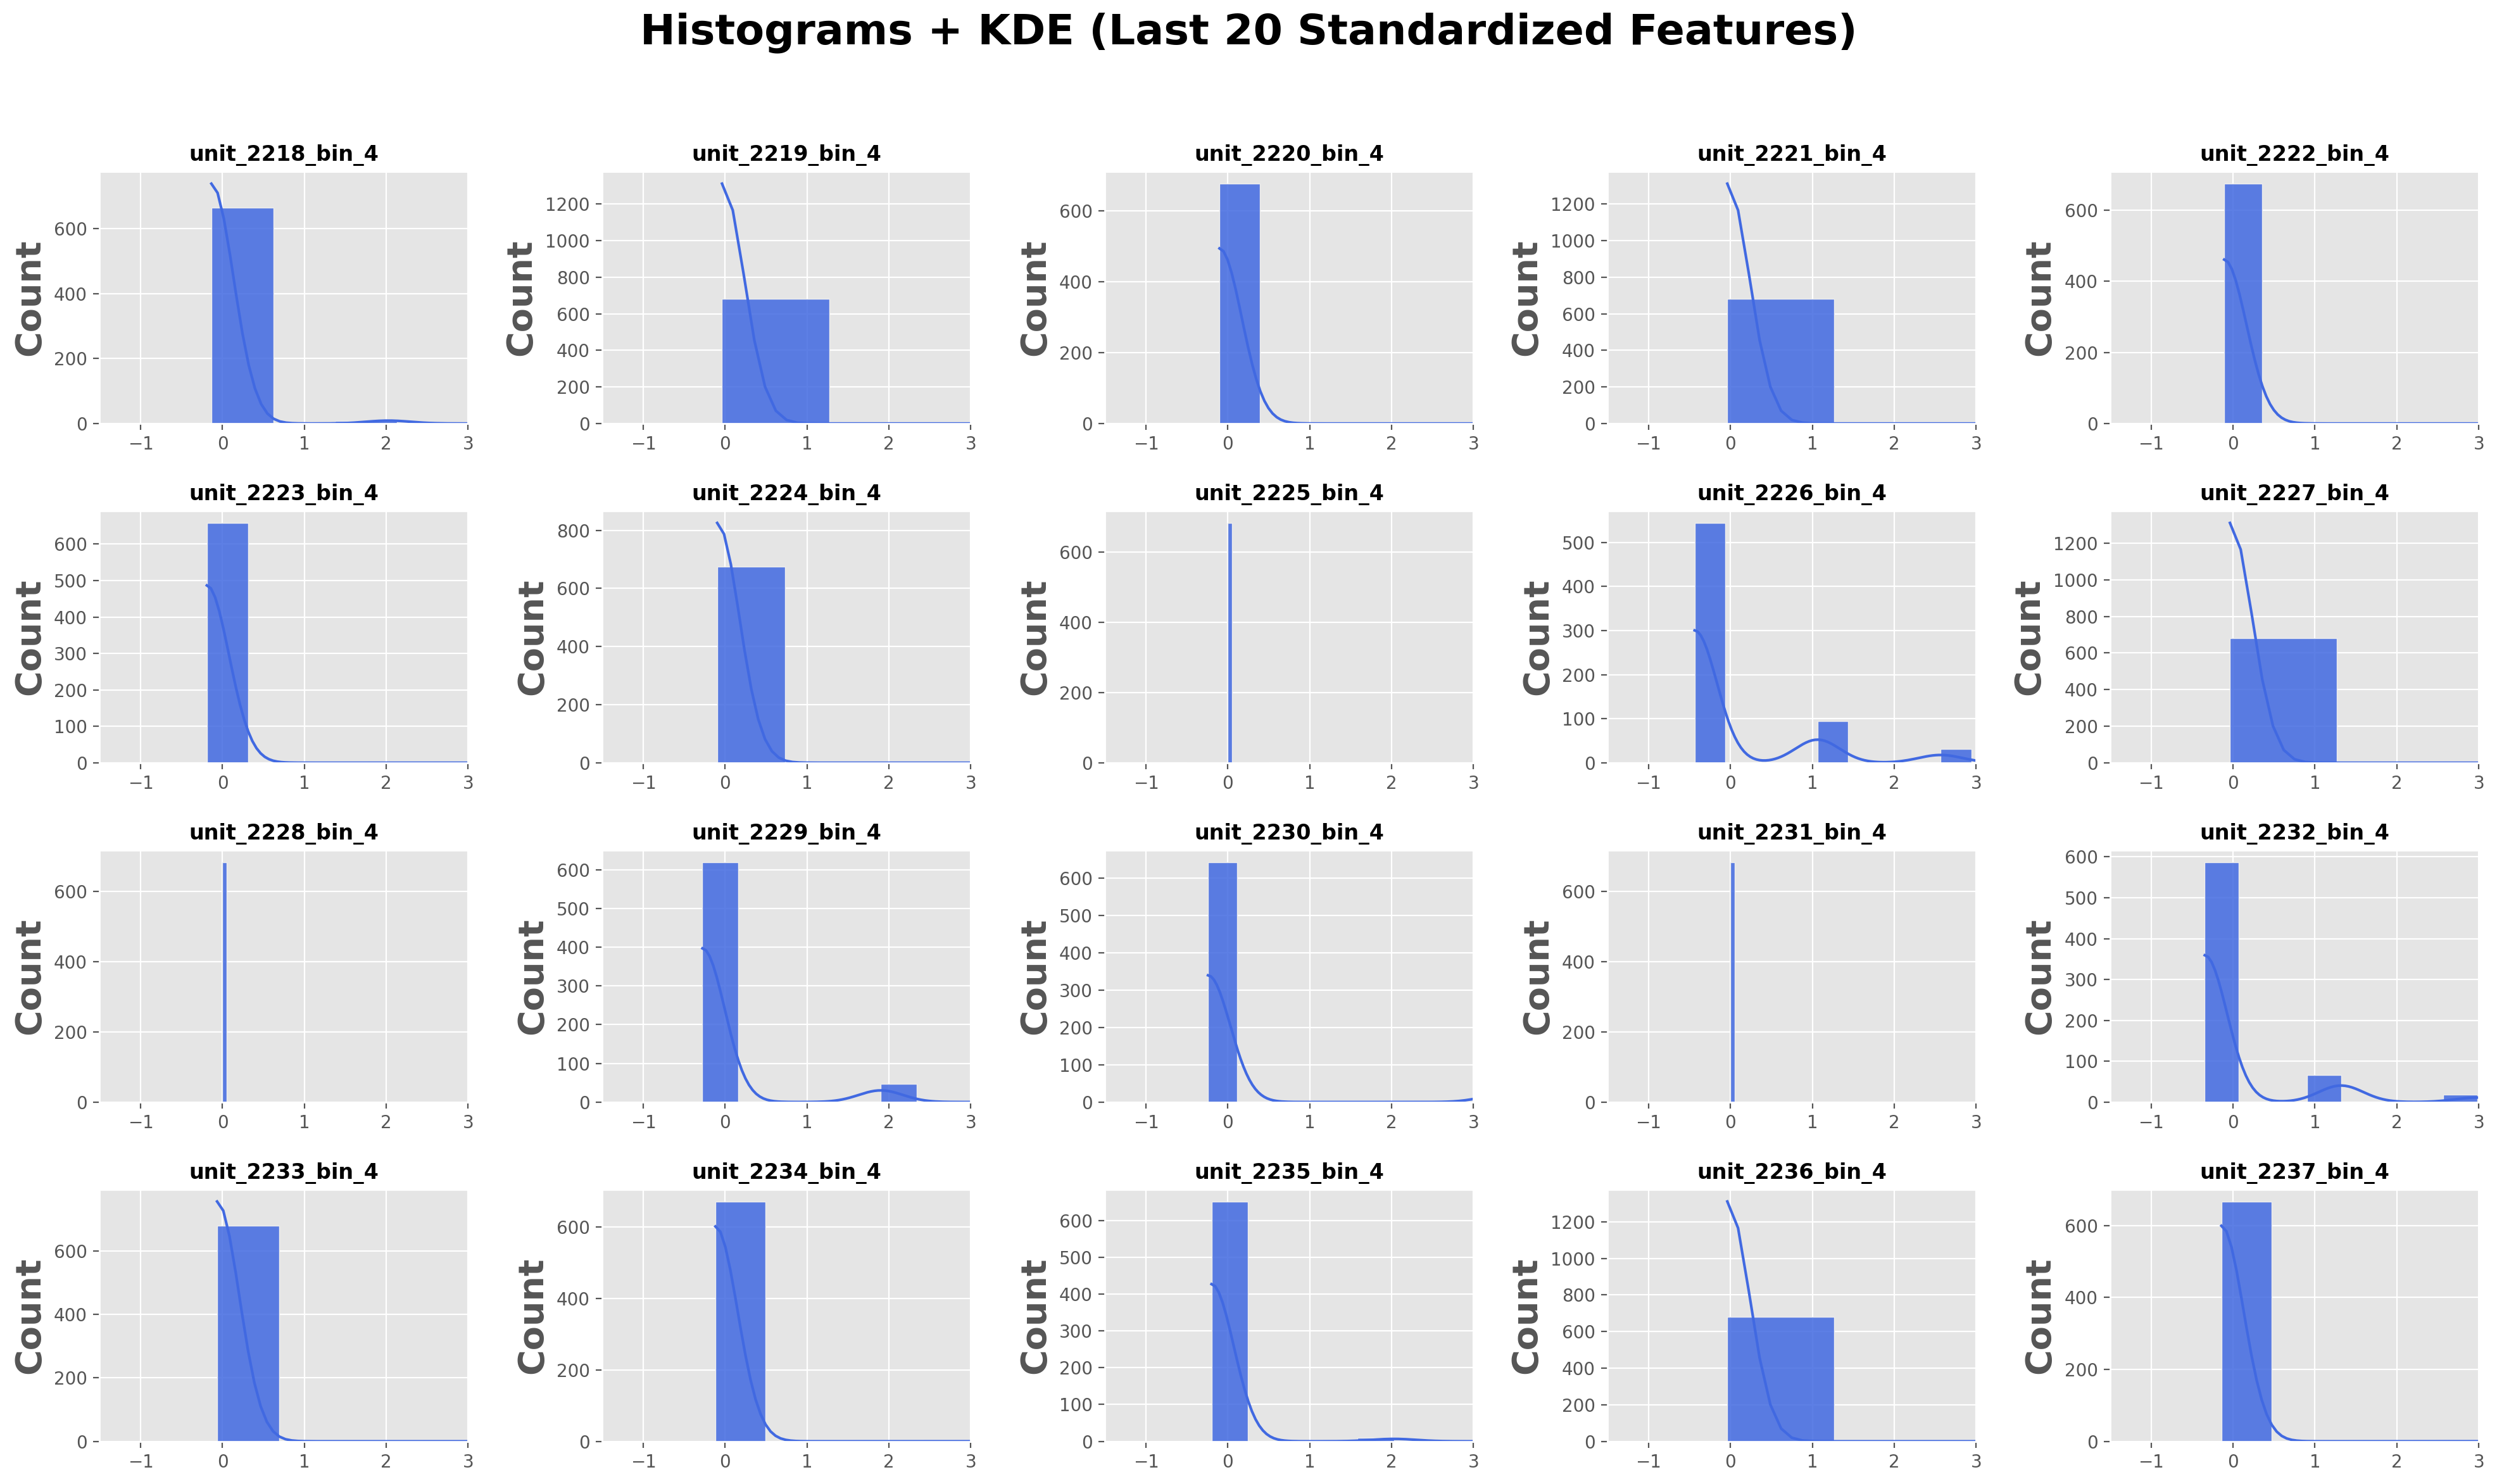


VARIANCE DISTRIBUTION BY CLASS


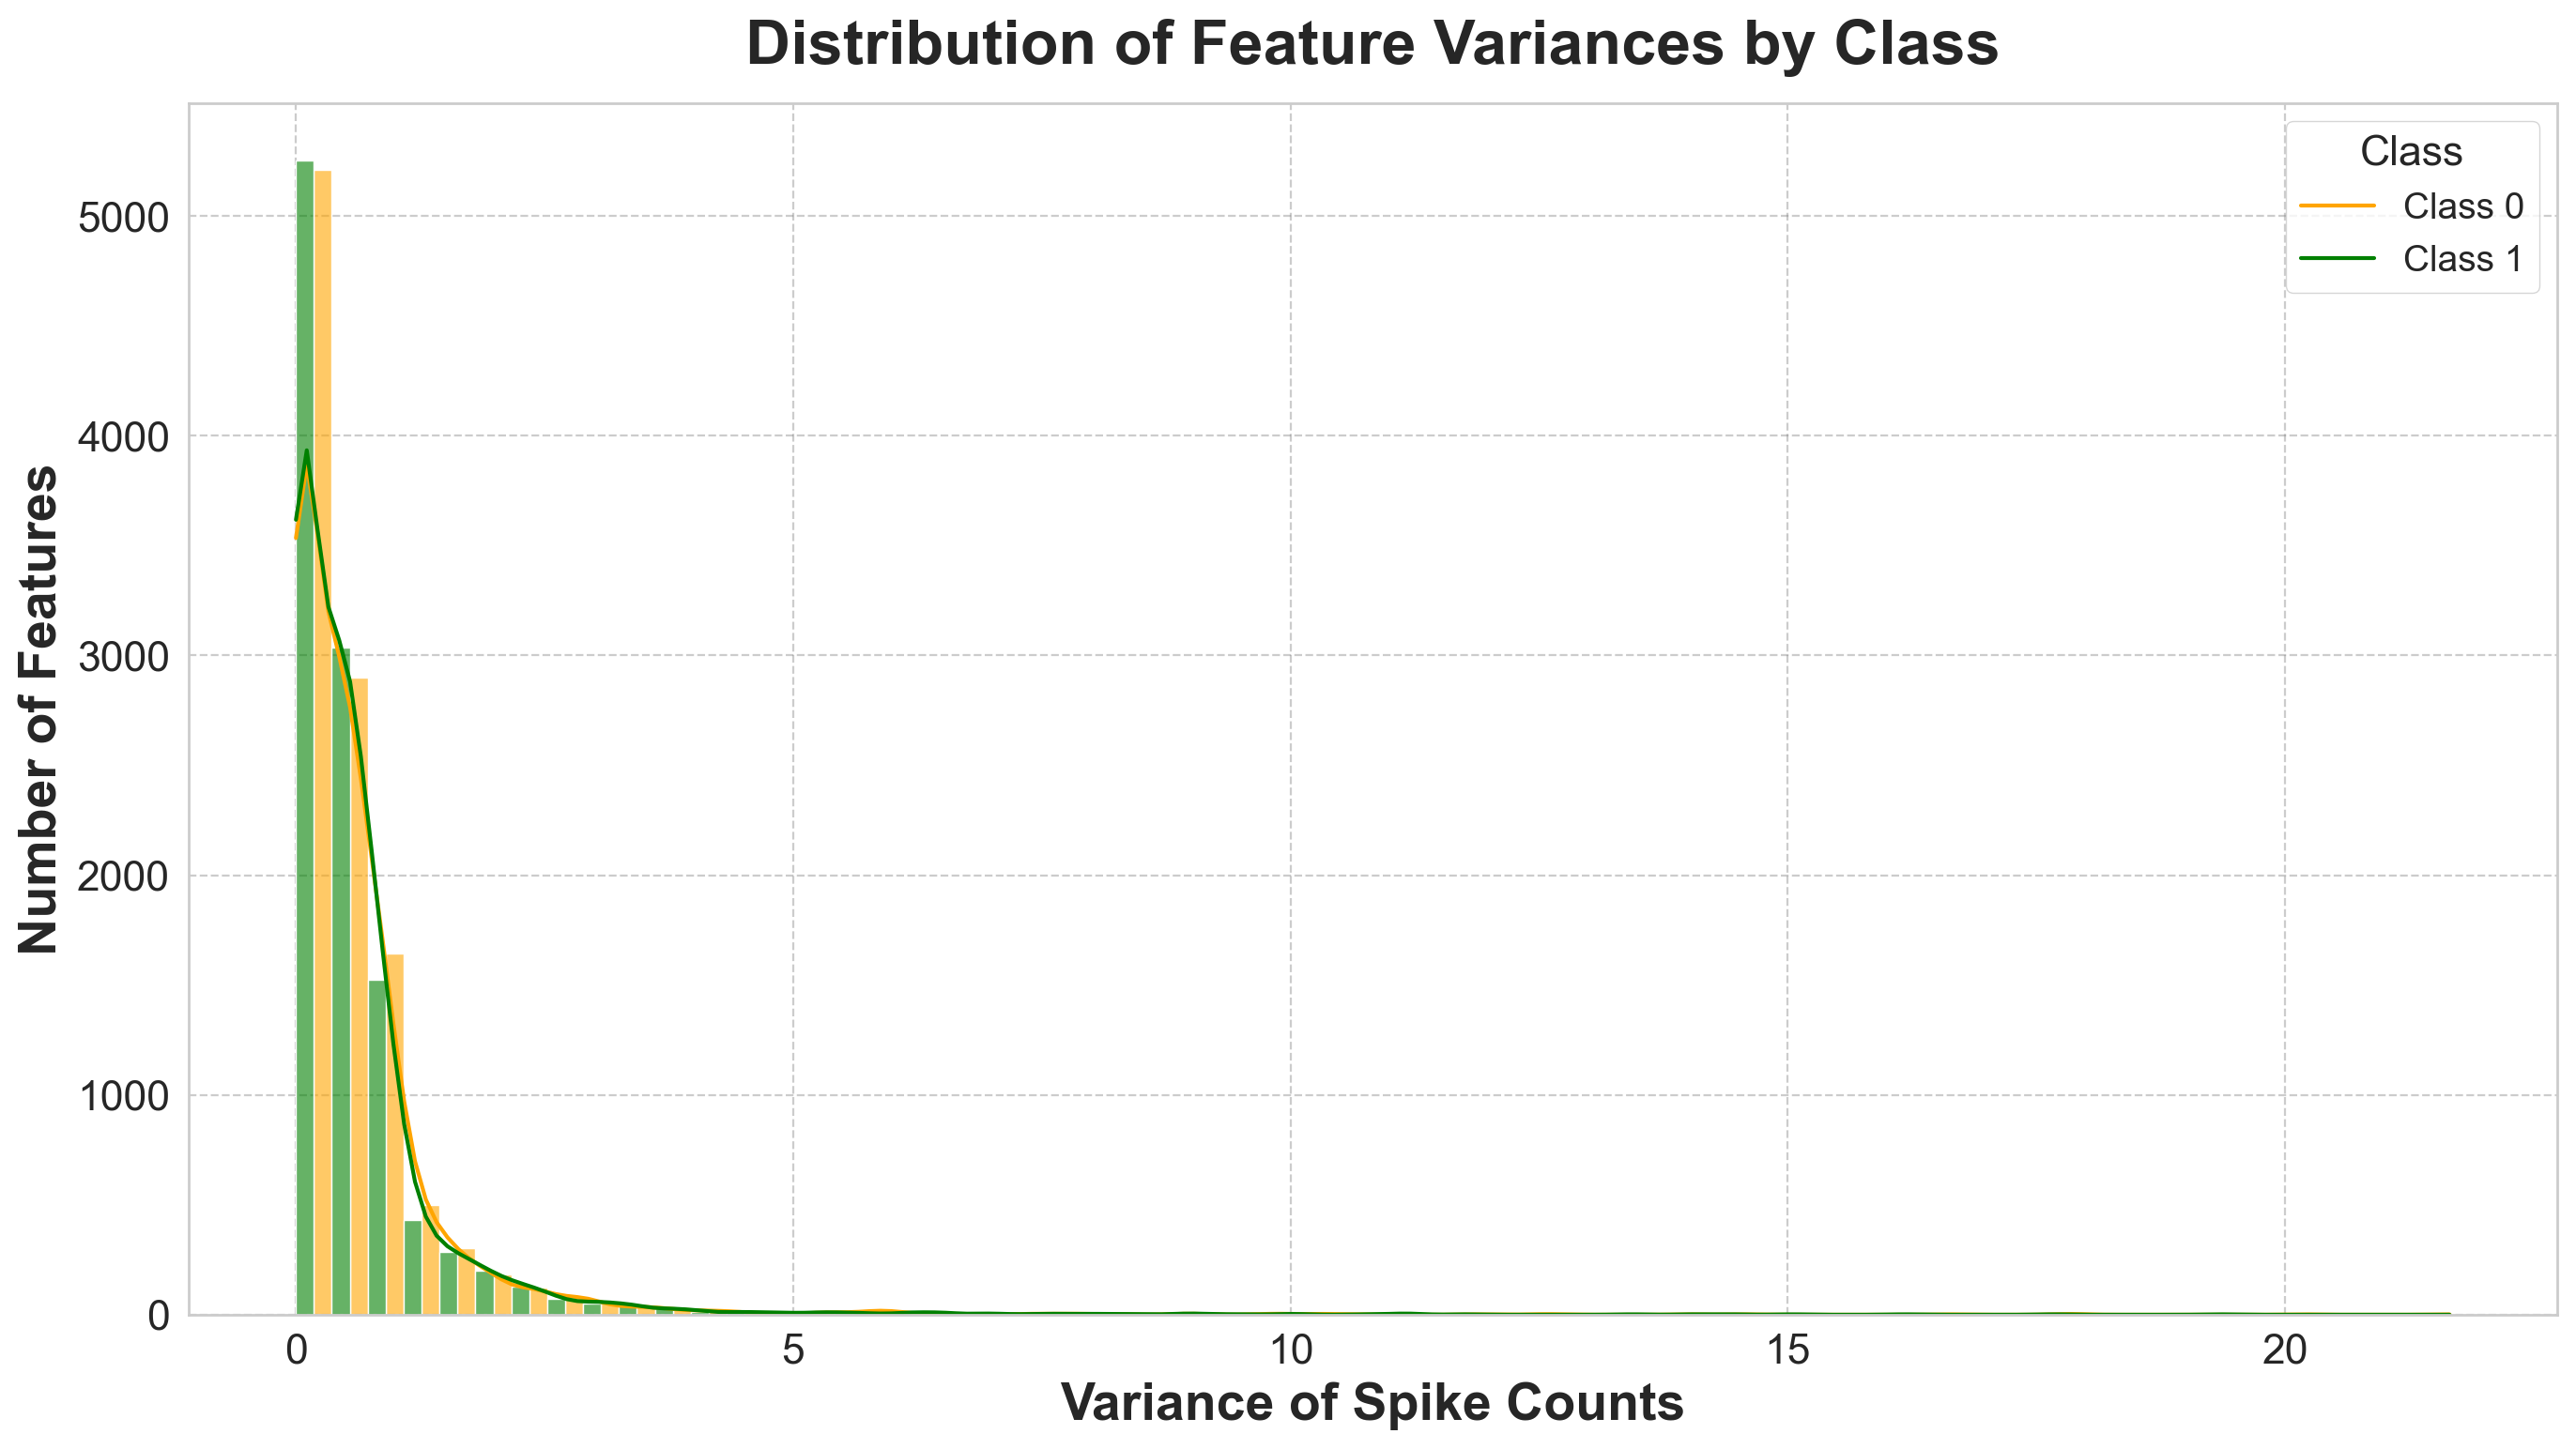


PCA PROJECTIONS



CUMULATIVE EXPLAINED VARIANCE
  80% variance explained at K = 422 PCs
  90% variance explained at K = 530 PCs
  95% variance explained at K = 597 PCs


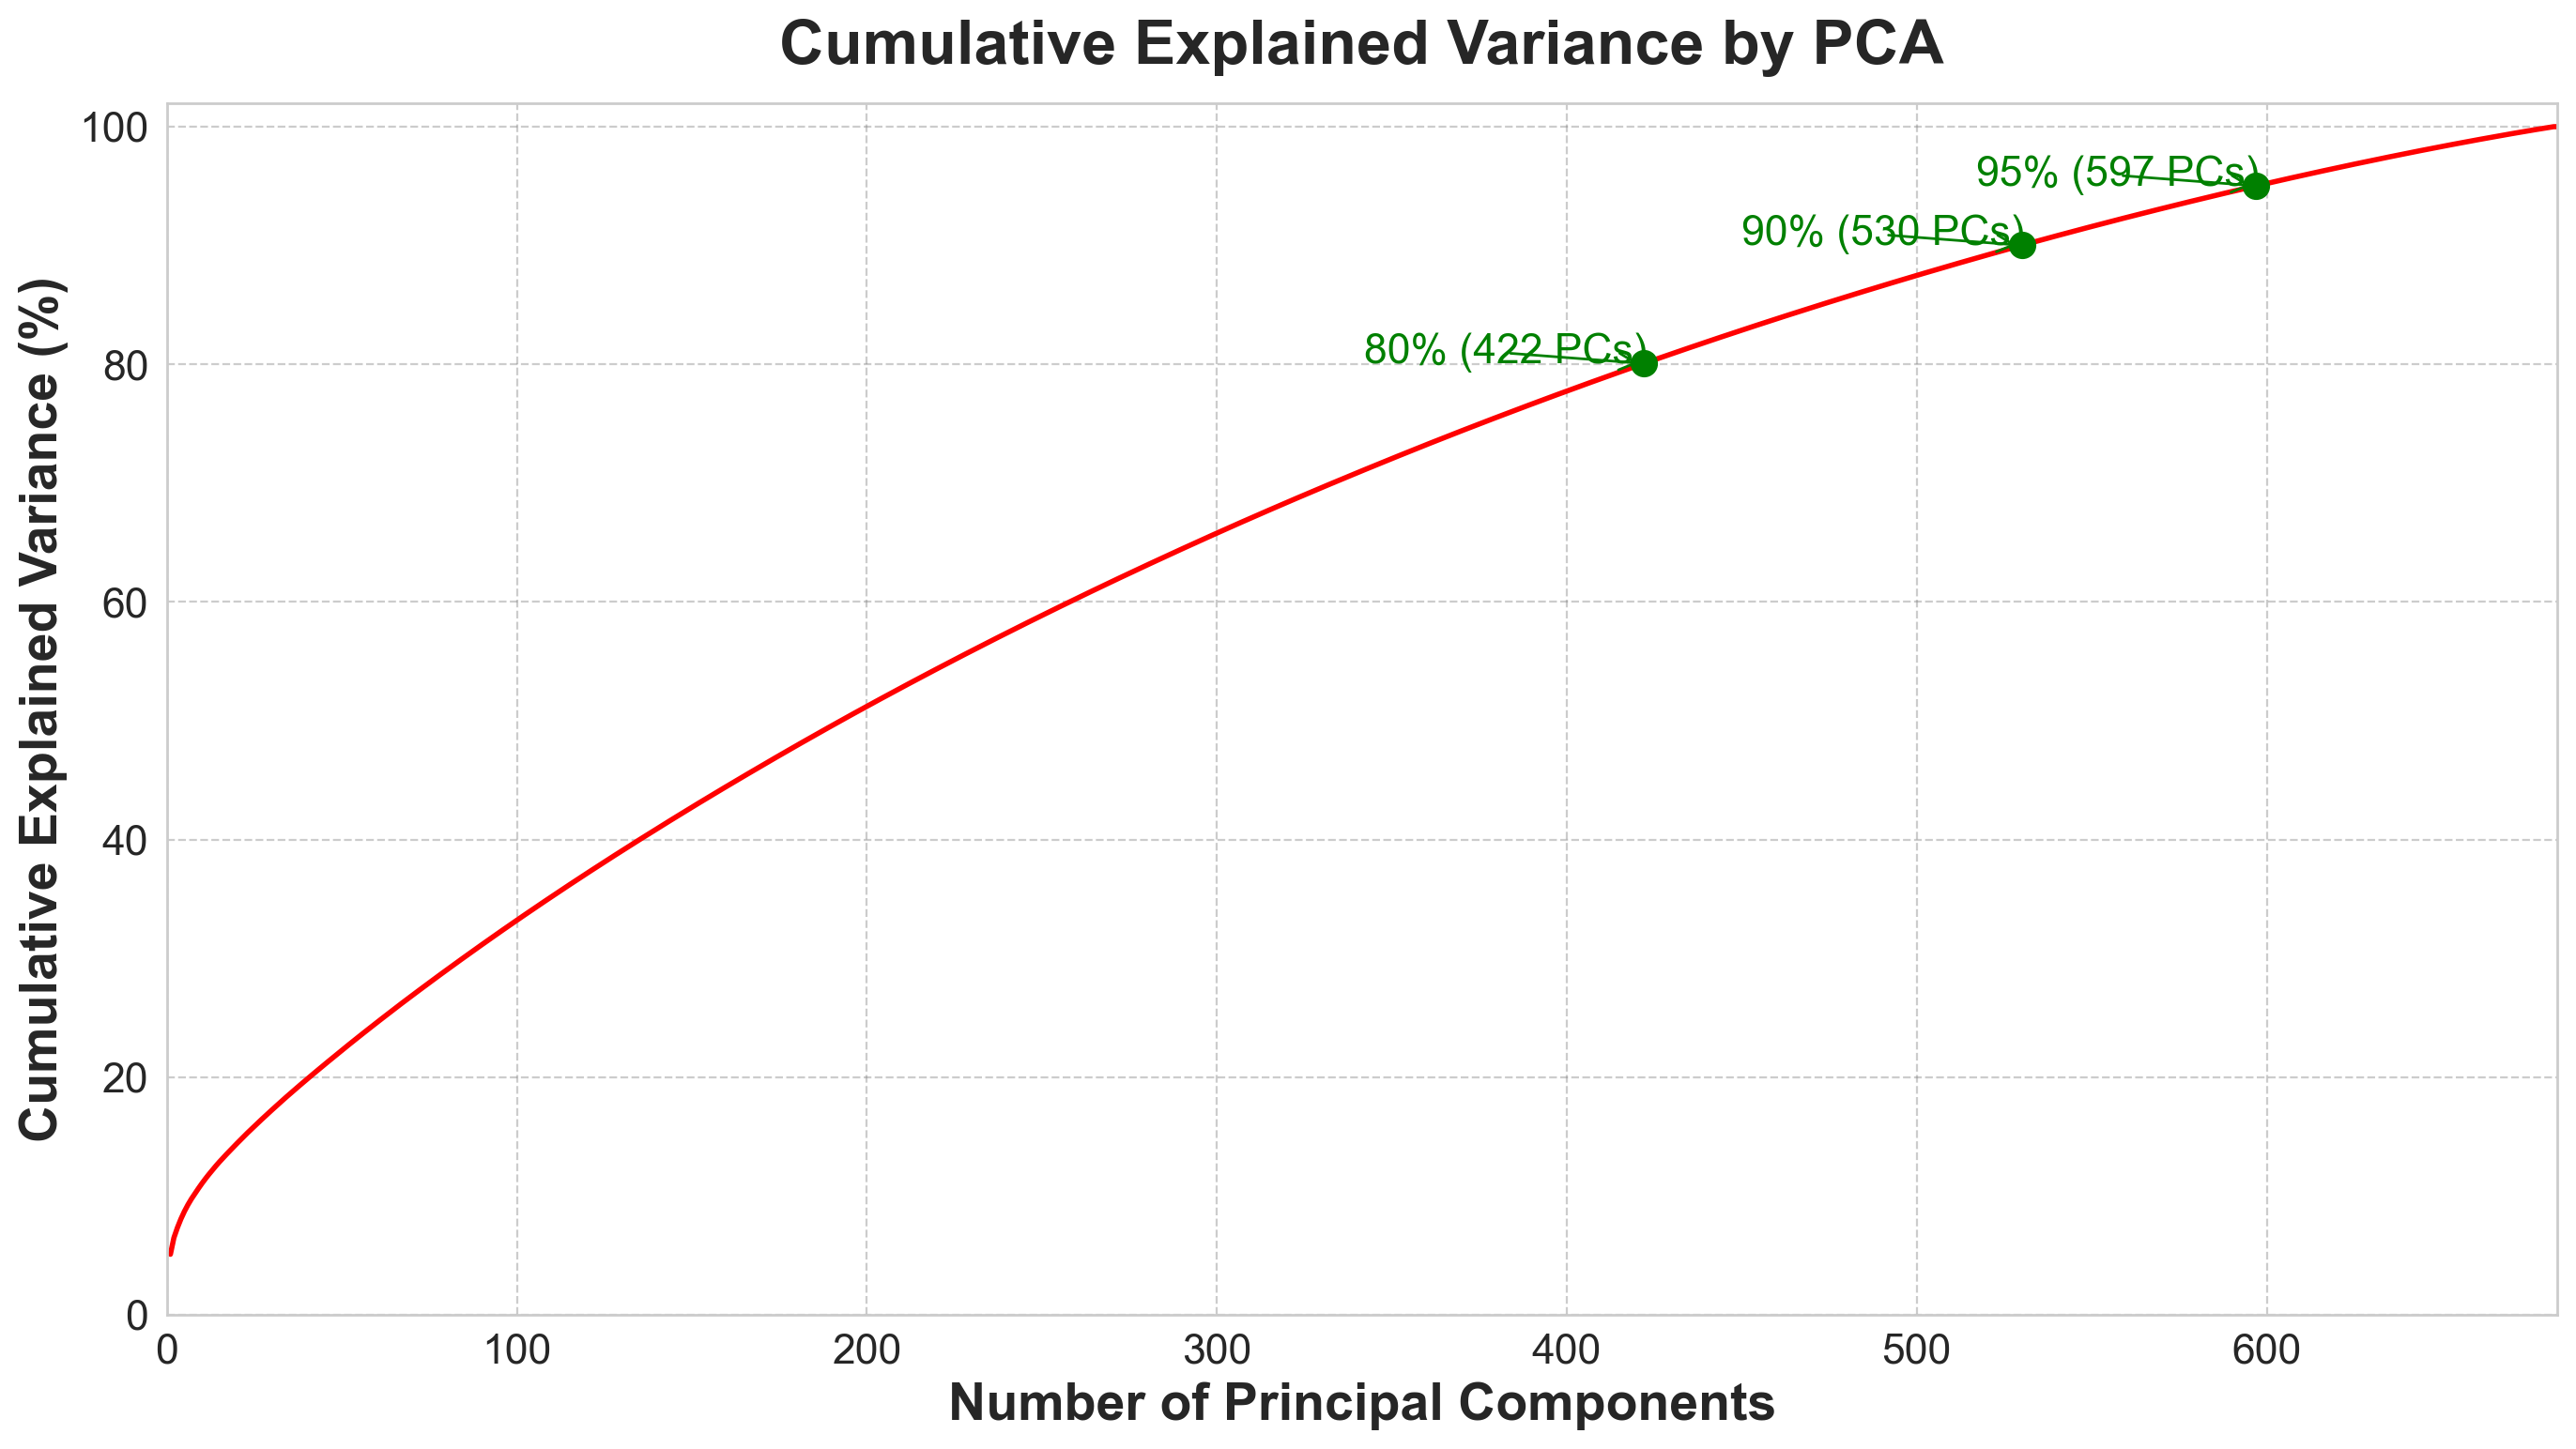

In [4]:
# -----------------------------------------------
# Feature distribution: Spike count histograms
# -----------------------------------------------
print("\n" + "="*60)
print("FEATURE DISTRIBUTIONS (STANDARDIZED)")
print("="*60)

scaler_eda = StandardScaler()
X_std = scaler_eda.fit_transform(X)
X_std_df = pd.DataFrame(X_std, columns=X.columns)

# First 20 features
plot_std_hists_kde(X_std_df, X_std_df.columns[:20], 
                   "Histograms + KDE (First 20 Standardized Features)", 
                   ncols=5, 
                   filename="hist_kde_first"
                   )

# Last 20 features
plot_std_hists_kde(X_std_df, X_std_df.columns[-20:], 
                   "Histograms + KDE (Last 20 Standardized Features)", 
                   ncols=5, 
                   filename="hist_kde_last"
                   )

# -----------------------------------------------
# Variance distribution by class
# -----------------------------------------------
print("\n" + "="*60)
print("VARIANCE DISTRIBUTION BY CLASS")
print("="*60)

var_0 = X[y == 0].var().values
var_1 = X[y == 1].var().values
var_df = pd.DataFrame({
    "variance": np.concatenate([var_0, var_1]),
    "label": np.repeat([0, 1], [len(var_0), len(var_1)])
})

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")  # Changed from "white" to "whitegrid"
sns.histplot(
    data=var_df, x="variance", hue="label", bins=60, kde=True,
    multiple="dodge", palette={0: "green", 1: "orange"},
    edgecolor="white", alpha=0.6, stat="count"
)

plt.title("Distribution of Feature Variances by Class", fontsize=FONT_TITLE, pad=15)
plt.xlabel("Variance of Spike Counts", fontsize=FONT_AXIS)
plt.ylabel("Number of Features", fontsize=FONT_AXIS)
plt.legend(title="Class", labels=["Class 0", "Class 1"], 
           title_fontsize=FONT_LEGEND, fontsize=FONT_LEGEND-2)
plt.grid(True, axis="both", linestyle="--", alpha=0.4, color="gray")  # Added gridlines on both axes
plt.tight_layout()

plt.savefig("variance.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# -----------------------------------------------
# 2D and 3D PCA projections
# -----------------------------------------------
print("\n" + "="*60)
print("PCA PROJECTIONS")
print("="*60)

pca_3 = PCA(n_components=3)
X_pca = pca_3.fit_transform(X_std)
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
df_pca["label"] = y.values

color_map = {0: "orange", 1: "green"}

fig_pca_proj = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "scatter"}, {"type": "scene"}]],
    subplot_titles=("2D PCA Projection", "3D PCA Projection"),
    horizontal_spacing=0.08
)

# 2D projection
for lbl in [0, 1]:
    mask = df_pca["label"] == lbl
    fig_pca_proj.add_trace(
        go.Scatter(
            x=df_pca.loc[mask, "PC1"], y=df_pca.loc[mask, "PC2"],
            mode="markers", marker=dict(size=5, color=color_map[lbl]),
            name=f"Class {lbl}", showlegend=False
        ), row=1, col=1
    )
fig_pca_proj.update_xaxes(title_text="PC1", title_font=dict(size=FONT_AXIS), row=1, col=1)
fig_pca_proj.update_yaxes(title_text="PC2", title_font=dict(size=FONT_AXIS), row=1, col=1)

# 3D projection
for lbl in [0, 1]:
    mask = df_pca["label"] == lbl
    fig_pca_proj.add_trace(
        go.Scatter3d(
            x=df_pca.loc[mask, "PC1"], y=df_pca.loc[mask, "PC2"], 
            z=df_pca.loc[mask, "PC3"],
            mode="markers", marker=dict(size=4, color=color_map[lbl]),
            name=f"Class {lbl}", showlegend=True
        ), row=1, col=2
    )
fig_pca_proj.update_scenes(
    xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3", row=1, col=2
)
fig_pca_proj.update_layout(
    template="plotly_white", width=1400, height=550,
    font=dict(size=FONT_TICK),
    legend=dict(font=dict(size=FONT_LEGEND))
)
fig_pca_proj.show()

# -----------------------------------------------
# Cumulative explained variance by PCA (Matplotlib version for report)
# -----------------------------------------------
print("\n" + "="*60)
print("CUMULATIVE EXPLAINED VARIANCE")
print("="*60)

pca_full = PCA().fit(X_std)
cum_var = pca_full.explained_variance_ratio_.cumsum() * 100
pcs = np.arange(1, len(cum_var) + 1)

# Find K at thresholds
thresholds = [80, 90, 95]
k_at_thresh = {t: int(np.argmax(cum_var >= t) + 1) for t in thresholds}

for t in thresholds:
    print(f"  {t}% variance explained at K = {k_at_thresh[t]} PCs")

# Create figure with same dimensions as variance plot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")  # Changed from "white" to "whitegrid"

# Main cumulative curve
plt.plot(pcs, cum_var, color="red", linewidth=2, label="Cumulative variance")

# Add threshold markers WITHOUT dashed lines
for t in thresholds:
    k = k_at_thresh[t]
    y_val = cum_var[k - 1]
    
    # Marker point only
    plt.scatter([k], [y_val], color="green", s=100, zorder=5)
    # Annotation - adjusted to appear on the LEFT of the marker
    plt.annotate(f"{t}% ({k} PCs)", xy=(k, y_val), xytext=(k - 80, y_val),
                 fontsize=FONT_ANNOT, color="green",
                 arrowprops=dict(arrowstyle="->", color="green", lw=1))

plt.title("Cumulative Explained Variance by PCA", fontsize=FONT_TITLE, pad=15)
plt.xlabel("Number of Principal Components", fontsize=FONT_AXIS)
plt.ylabel("Cumulative Explained Variance (%)", fontsize=FONT_AXIS)
plt.xlim(0, len(pcs))
plt.ylim(0, 102)
plt.grid(True, axis="both", linestyle="--", alpha=0.4, color="gray")
plt.tight_layout()
plt.savefig("pca.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

In [5]:
# =============================================================================
# CORRELATION STRUCTURE ANALYSIS
# =============================================================================
print("\n" + "="*60)
print("FEATURE CORRELATION STRUCTURE")
print("="*60)

# -----------------------------------------------------------------------------
# FULL DATASET CORRELATION STATISTICS (cached)
# -----------------------------------------------------------------------------
def compute_full_correlation_stats():
    """Compute correlation statistics for all features."""
    print("Computing correlation statistics for ALL features...")
    
    t0 = time.perf_counter()
    
    # Compute full correlation matrix
    corr_matrix_full = X.corr()
    n_features = X.shape[1]
    
    # Extract upper triangle (excluding diagonal)
    corr_values_raw = corr_matrix_full.values[np.triu_indices(n_features, k=1)]
    corr_values = corr_values_raw[~np.isnan(corr_values_raw)]
    
    n_nan = np.sum(np.isnan(corr_values_raw))
    runtime = time.perf_counter() - t0
    
    # Compute all statistics
    stats = {
        "n_features": n_features,
        "n_pairs_total": len(corr_values_raw),
        "n_pairs_valid": len(corr_values),
        "n_nan": n_nan,
        "mean": np.mean(corr_values),
        "std": np.std(corr_values),
        "min": np.min(corr_values),
        "max": np.max(corr_values),
        "median": np.median(corr_values),
        "avg_abs": np.mean(np.abs(corr_values)),
        "high_pos": np.sum(corr_values > 0.7),
        "high_neg": np.sum(corr_values < -0.7),
        "moderate": np.sum((np.abs(corr_values) > 0.3) & (np.abs(corr_values) <= 0.7)),
        "runtime": runtime
    }
    
    return stats

# Load or compute full correlation stats
corr_stats_full = load_or_compute("corr_stats_full.pkl", compute_full_correlation_stats)

# Display full dataset statistics
print(f"\nFull dataset correlation (n = {corr_stats_full['n_features']} features):")
print(f"  Computation time: {corr_stats_full['runtime']:.1f} seconds")
print(f"  Total pairwise correlations: {corr_stats_full['n_pairs_total']:,}")
print(f"  NaN correlations (zero-variance): {corr_stats_full['n_nan']:,}")
print(f"  Valid correlations: {corr_stats_full['n_pairs_valid']:,}")

print(f"\nCorrelation statistics (ALL features):")
print(f"  Mean:   {corr_stats_full['mean']:.4f}")
print(f"  Std:    {corr_stats_full['std']:.4f}")
print(f"  Min:    {corr_stats_full['min']:.4f}")
print(f"  Max:    {corr_stats_full['max']:.4f}")
print(f"  Median: {corr_stats_full['median']:.4f}")

avg_abs_corr_full = corr_stats_full['avg_abs']
print(f"\n  >>> Average |correlation| (FULL): {avg_abs_corr_full:.4f} <<<")

print(f"\nCorrelation breakdown (ALL features):")
n_valid = corr_stats_full['n_pairs_valid']
print(f"  High positive (>0.7):  {corr_stats_full['high_pos']:,} ({100*corr_stats_full['high_pos']/n_valid:.2f}%)")
print(f"  High negative (<-0.7): {corr_stats_full['high_neg']:,} ({100*corr_stats_full['high_neg']/n_valid:.2f}%)")
print(f"  Moderate (0.3-0.7):    {corr_stats_full['moderate']:,} ({100*corr_stats_full['moderate']/n_valid:.2f}%)")

# -----------------------------------------------------------------------------
# SUBSET FOR VISUALIZATION (first 500 features)
# -----------------------------------------------------------------------------
print("\n" + "-"*60)
print("HEATMAP VISUALIZATION (First 500 Features)")
print("-"*60)

n_corr_features = 500
X_corr_subset = X.iloc[:, :n_corr_features]

# Correlation matrix for visualization
corr_matrix = X_corr_subset.corr()

# Summary stats for subset
corr_values_raw = corr_matrix.values[np.triu_indices(n_corr_features, k=1)]
corr_values = corr_values_raw[~np.isnan(corr_values_raw)]

n_nan = np.sum(np.isnan(corr_values_raw))
print(f"\nSubset correlation (first {n_corr_features} features):")
print(f"  Total pairwise correlations: {len(corr_values_raw):,}")
print(f"  NaN correlations: {n_nan:,}")
print(f"  Valid correlations: {len(corr_values):,}")

avg_abs_corr_subset = np.mean(np.abs(corr_values))
print(f"  Average |correlation| (subset): {avg_abs_corr_subset:.4f}")

# -----------------------------------------------------------------------------
# Heatmap
# -----------------------------------------------------------------------------
fig_corr = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='RdBu',
    zmid=0,
    zmin=-1,
    zmax=1,
    colorbar=dict(
        title=dict(text="Correlation", font=dict(size=FONT_AXIS)),
        tickfont=dict(size=FONT_TICK),
        thickness=20,
        len=0.75
    ),
    hovertemplate="Feature X: %{x}<br>Feature Y: %{y}<br>Correlation: %{z:.3f}<extra></extra>"
))

fig_corr.update_layout(
    title=dict(
        text=f"<b>Feature Correlation Heatmap (First {n_corr_features} Features)</b>",
        font=dict(size=FONT_TITLE)
    ),
    xaxis=dict(title="", showticklabels=True, ticks=""),
    yaxis=dict(title="", showticklabels=True, ticks="", autorange="reversed"),
    template="plotly_white",
    width=900,
    height=800
)
fig_corr.show()
save_plotly_pdf(fig_corr, "correlation", 900, 800)

# -----------------------------------------------------------------------------
# INTERPRETATION (based on FULL dataset)
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("CORRELATION STRUCTURE INTERPRETATION (Full Dataset)")
print("="*60)

print(f"\nAverage absolute correlation (all {corr_stats_full['n_features']} features): {avg_abs_corr_full:.4f}")

if avg_abs_corr_full < 0.15:
    interpretation = "LOW correlation structure - features are largely independent"
    signal_noise = "HIGH NOISE / LOW SIGNAL: Information is distributed across many weak features. Aggressive feature selection may discard useful signal."
elif avg_abs_corr_full < 0.35:
    interpretation = "MODERATE correlation structure - some feature dependencies exist"
    signal_noise = "MODERATE signal with some redundancy between features. Some dimensionality reduction possible."
else:
    interpretation = "HIGH correlation structure - strong feature dependencies"
    signal_noise = "HIGH SIGNAL: Significant redundancy that can be exploited for dimensionality reduction."

print(f"\nInterpretation: {interpretation}")
print(f"\n{signal_noise}")


FEATURE CORRELATION STRUCTURE
[Cache] Loaded from corr_stats_full.pkl

Full dataset correlation (n = 10654 features):
  Computation time: 123.5 seconds
  Total pairwise correlations: 56,748,531
  NaN correlations (zero-variance): 0
  Valid correlations: 56,748,531

Correlation statistics (ALL features):
  Mean:   0.0045
  Std:    0.0661
  Min:    -0.5306
  Max:    1.0000
  Median: -0.0040

  >>> Average |correlation| (FULL): 0.0456 <<<

Correlation breakdown (ALL features):
  High positive (>0.7):  6,563 (0.01%)
  High negative (<-0.7): 0 (0.00%)
  Moderate (0.3-0.7):    192,952 (0.34%)

------------------------------------------------------------
HEATMAP VISUALIZATION (First 500 Features)
------------------------------------------------------------

Subset correlation (first 500 features):
  Total pairwise correlations: 124,750
  NaN correlations: 8,347
  Valid correlations: 116,403
  Average |correlation| (subset): 0.0507


✓ Saved: correlation.pdf

CORRELATION STRUCTURE INTERPRETATION (Full Dataset)

Average absolute correlation (all 10654 features): 0.0456

Interpretation: LOW correlation structure - features are largely independent

HIGH NOISE / LOW SIGNAL: Information is distributed across many weak features. Aggressive feature selection may discard useful signal.


### **EDA SUMMARY INSIGHTS**

##### **1. High p >> n setting**
*Observation:* 11,190 features and 683 samples (p >> n by ~16×)

*Implication:* Extreme **p >> n** scenario where standard classifiers will overfit without dimensionality reduction or regularisation. Feature selection is mandatory for variance control and computational tractability


##### **2. Class imbalance**
*Observation:* Target distribution is skewed: Left (0): ~30.5%, Right (1): ~69.5%.

*Implication:* Accuracy would be misleading as a metric. **Balanced accuracy** will be the primary evaluation metric throughout modelling.


##### **3. Low signal to noise ratio**
*Observations:*
- **Sparse signals** Spike-count histograms show most neuron-timebin features have near-zero values
- **Seemingly "dead" features** Variance analysis reveals 536 features with zero variance and ~6,000 with variance ≤ 0.5, suggesting many appear uninformative in isolation
- **Distributed information** PCA requires 422 components for 80% variance, 530 for 90%, 597 for 95%. No elbow exists thus signal is spread across hundreds of weak features rather than concentrated in a few strong ones
- **Uncorrelated features** Correlation heatmap confirms features are largely uncorrelated (avg |ρ| < 0.05), meaning each feature carries minimal individual information but collectively encodes predictive structure

*Implication:* **Low signal-to-noise ratio** dataset. No obvious "important" feature subset exists. Aggressive pre-filtering risks discarding real signal; retaining too many hurts generalization. Optimal K likely lies in the mid-range (tens to hundreds)

### **FEATURE SELECTION EVALUATION STRATEGY**

We will compare six feature selection methods to answer: ***How many features are necessary to extract behavioural information?***

*Evaluation Criteria:*

| Criterion | Weight | Rationale |
|-----------|--------|-----------|
| **Optimal K** | 45% | Minimum features needed for peak performance |
| **Balanced Accuracy** | 45% | Predictive performance on held-out test set |
| **Runtime** | 10% | Secondary consideration; varies with computational resources |

For each method, we compute balanced accuracy across a range of K values to identify where performance plateaus and whether methods differ in their optimal dimensionality.

*Expectations:*
- Balanced accuracy will improve gradually with K, plateauing after many features
- No method will reduce dimensionality to a trivially small feature set
- Different methods will achieve peak performance at different K values

# **T 2.2: FEATURE SELECTION METHODS**

### **T 2.2.0: DATA PRE-PROCESSING**

In [6]:
# =============================================================================
# DATA PRE-PROCESSING
# =============================================================================
print("="*60)
print("DATA PRE-PROCESSING")
print("="*60)

# Remove zero-value columns
print(f"Dropping {zero_cols.sum()} all-zero columns")
X = X.loc[:, ~zero_cols]
print(f"Features after removal: {X.shape[1]}")

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE, shuffle=True
)
print(f"\nX_train: {X_tr.shape}")
print(f"X_test:  {X_te.shape}")
print(f"y_train: {y_tr.shape}")
print(f"y_test:  {y_te.shape}")

# =============================================================================
# FEATURE SELECTION HELPER FUNCTIONS
# =============================================================================
def make_pipeline(model):
    """Create pipeline with fresh StandardScaler instance."""
    return Pipeline([("scaler", StandardScaler()), ("model", model)])

def get_base_models():
    """Return dictionary of base classifiers for comparison."""
    return {
        "LogReg": LogisticRegression(
            solver="liblinear", class_weight="balanced",
            max_iter=1000, random_state=RANDOM_STATE
        ),
        "SVM_linear": SVC(
            kernel="linear", class_weight="balanced",
            probability=True, random_state=RANDOM_STATE
        ),
        "kNN": KNeighborsClassifier(n_neighbors=10),
        "RF": RandomForestClassifier(
            n_estimators=100, max_depth=5, class_weight="balanced",
            random_state=RANDOM_STATE, n_jobs=-1
        )
    }

def evaluate_models(X_tr_sel, X_te_sel, y_tr, y_te, method_name):
    """Evaluate all base models on selected features, return results DataFrame."""
    results = []
    for name, model in get_base_models().items():
        t0 = time.perf_counter()
        pipe = make_pipeline(model)
        pipe.fit(X_tr_sel, y_tr)
        runtime = time.perf_counter() - t0
        
        y_pred = pipe.predict(X_te_sel)
        if hasattr(pipe.named_steps["model"], "predict_proba"):
            y_score = pipe.predict_proba(X_te_sel)[:, 1]
        else:
            y_score = pipe.decision_function(X_te_sel)
        
        results.append({
            "Feature Selection": method_name,
            "Model": name,
            "Accuracy": fmt(accuracy_score(y_te, y_pred)),
            "Balanced Acc": fmt(balanced_accuracy_score(y_te, y_pred)),
            "F1-score": fmt(f1_score(y_te, y_pred)),
            "ROC-AUC": fmt(roc_auc_score(y_te, y_score)),
            "Runtime (s)": fmt(runtime)
        })
    return pd.DataFrame(results)

K_STANDARD_GRID = list(range(5, 205, 5)) # Standard grid for K values to evaluate balanced accuracy

def plot_ba_vs_k(df, method, x_col="K", y_col="Bal_Acc"):
    """Plot balanced accuracy vs K with highlighted best point."""
    fig = px.line(df, x=x_col, y=y_col, markers=True)
    fig.update_traces(
        line=dict(width=2),
        marker=dict(size=8),
        hovertemplate=f"{x_col}=%{{x}}<br>Balanced Acc=%{{y:.3f}}<extra></extra>"
    )
    
    # Highlight best point
    best_idx = df[y_col].idxmax()
    best_row = df.loc[best_idx]
    fig.add_scatter(
        x=[best_row[x_col]], y=[best_row[y_col]],
        mode="markers+text",
        marker=dict(color="red", size=14, symbol="star"),
        text=[f"Highest BA = {best_row[y_col]:.3f}<br> at K = {int(best_row[x_col])}"],
        textposition="top center",
        textfont=dict(size=FONT_ANNOT, color="red"),
        showlegend=False,
        hovertemplate=f"<b>BEST</b><br>{x_col}=%{{x}}<br>BA=%{{y:.3f}}<extra></extra>"
    )
    
    plotly_layout(fig, f"{method}: Balanced Accuracy vs K",
                  "Number of Selected Features (K)", "Balanced Accuracy", [0.5, 1])
    return fig

def plot_model_comparison(df, method, k_opt):
    """Scatter plot comparing models at optimal K."""
    fig = px.scatter(
        df, x="Model", y="Balanced Acc", color="Model",
        size=[15]*len(df), text="Balanced Acc"
    )
    fig.update_traces(
        mode="markers+text",
        texttemplate="%{text:.3f}",
        textposition="top center",
        textfont=dict(size=FONT_ANNOT),
        hovertemplate="Model: %{x}<br>Balanced Acc: %{y:.3f}<extra></extra>"
    )
    plotly_layout(fig, f"{method} Model Comparison at K = {k_opt}",
                  "Model", "Balanced Accuracy", [0.5, 1])
    return fig

DATA PRE-PROCESSING
Dropping 536 all-zero columns
Features after removal: 10654

X_train: (546, 10654)
X_test:  (137, 10654)
y_train: (546,)
y_test:  (137,)


### **T 2.2.1: FORWARD STEPWISE SELECTION (FSS)**

In [7]:
print("\n" + "="*60)
print("T 2.2.1: FORWARD STEPWISE SELECTION (AIC)")
print("="*60)

# a) Feature selection
def fss_aic_selection(X, y, max_features=200, verbose=True):
    """Forward stepwise selection using AIC with logistic regression."""
    y_arr = np.asarray(y)
    selected = []
    remaining = list(X.columns)
    records = []
    
    for step in range(1, max_features + 1):
        if not remaining:
            if verbose:
                print(f"No remaining features at step {step}, stopping.")
            break
        
        best_feat, best_aic = None, np.inf
        for cand in remaining:
            cols = selected + [cand]
            X_sub = sm.add_constant(X[cols], has_constant="add")
            try:
                model = sm.Logit(y_arr, X_sub).fit(disp=0)
                aic = model.aic
            except Exception:
                continue
        
            if aic < best_aic:
                best_aic = aic
                best_feat = cand
        
        if best_feat is None:
            if verbose:
                print(f"No valid candidate at step {step}, stopping.")
            break
        
        selected.append(best_feat)
        remaining.remove(best_feat)
        records.append({"K": len(selected), "Feature": best_feat, "AIC": best_aic})
        
        if verbose:
            print(f"Step {step}: added {best_feat}, K={len(selected)}, AIC={best_aic:.3f}")
    
    return selected, pd.DataFrame(records)

MAX_FEATURES_FSS = 200

def compute_fss():
    t0 = time.perf_counter()
    feats, aic_df = fss_aic_selection(X_tr, y_tr, max_features=MAX_FEATURES_FSS, verbose=True)
    runtime = time.perf_counter() - t0
    return {"feats": feats, "aic_df": aic_df, "time_select": runtime}

fss_cache = load_or_compute("fss_aic.pkl", compute_fss)
fss_feats = fss_cache["feats"]
fss_aic_df = fss_cache["aic_df"]
fss_time_select = fss_cache["time_select"]

print(f"\nFSS selection runtime: {fss_time_select:.2f} seconds")
show_df(fss_aic_df, "FSS AIC Results")

# Plot: AIC vs K
fig_fss_aic = px.line(fss_aic_df, x="K", y="AIC", markers=True)
fig_fss_aic.update_traces(
    hovertemplate="K = %{x}<br>AIC = %{y:.3f}<extra></extra>"
)
plotly_layout(fig_fss_aic, "FSS (AIC): AIC vs Number of Selected Features",
              "Number of Selected Features (K)", "AIC")
fig_fss_aic.show()
save_plotly_pdf(fig_fss_aic, "fss_aic_vs_k")

# b) Balanced accuracy over K values
print("\n--- Evaluating FSS over K values ---")
fss_ba_records = []
t0_eval = time.perf_counter()

for K in K_STANDARD_GRID:
    if K > len(fss_feats):
        continue
    feats_k = fss_feats[:K]
    pipe = make_pipeline(LogisticRegression(
        solver="liblinear", class_weight="balanced",
        max_iter=1000, random_state=RANDOM_STATE
    ))
    pipe.fit(X_tr[feats_k], y_tr)
    y_pred = pipe.predict(X_te[feats_k])
    ba = balanced_accuracy_score(y_te, y_pred)
    fss_ba_records.append({"Method": "FSS", "K": K, "Bal_Acc": fmt(ba)})

fss_time_eval = time.perf_counter() - t0_eval
fss_time_total = fss_time_select + fss_time_eval

fss_ba_df = pd.DataFrame(fss_ba_records)
print(f"FSS evaluation runtime: {fss_time_eval:.2f} seconds")
print(f"FSS total runtime: {fss_time_total:.2f} seconds")
show_df(fss_ba_df, "FSS Balanced Accuracy (first 10)")

# Plot: BA vs K
fig_fss_ba = plot_ba_vs_k(fss_ba_df, "FSS")
fig_fss_ba.show()

# c) Model comparison at optimal K
idx_best_fss = fss_ba_df["Bal_Acc"].idxmax()
K_opt_fss = int(fss_ba_df.loc[idx_best_fss, "K"])
print(f"\nOptimal K from FSS: {K_opt_fss}")

fss_results_df = evaluate_models(
    X_tr[fss_feats[:K_opt_fss]], X_te[fss_feats[:K_opt_fss]], 
    y_tr, y_te, "Forward Stepwise"
)
show_df(fss_results_df, f"FSS Model Comparison at K = {K_opt_fss}")

fig_fss_models = plot_model_comparison(fss_results_df, "FSS", K_opt_fss)
fig_fss_models.show()


T 2.2.1: FORWARD STEPWISE SELECTION (AIC)
[Cache] Loaded from fss_aic.pkl

FSS selection runtime: 19377.07 seconds

FSS AIC Results


K          Feature      AIC
0    1  unit_0744_bin_4  633.184
1    2  unit_0920_bin_1  596.448
2    3  unit_0855_bin_0  572.486
3    4  unit_0697_bin_3  550.722
4    5  unit_0834_bin_3  531.056
..  ..              ...      ...
85  86  unit_0969_bin_4  122.323
86  87  unit_1100_bin_4  124.323
87  88  unit_2054_bin_4  124.323
88  89  unit_0239_bin_1  126.324
89  90  unit_0615_bin_2  128.305

[90 rows x 3 columns]

✓ Saved: fss_aic_vs_k.pdf

--- Evaluating FSS over K values ---
FSS evaluation runtime: 0.32 seconds
FSS total runtime: 19377.39 seconds

FSS Balanced Accuracy (first 10)


Method   K  Bal_Acc
0     FSS   5    0.645
1     FSS  10    0.674
2     FSS  15    0.667
3     FSS  20    0.682
4     FSS  25    0.739
5     FSS  30    0.774
6     FSS  35    0.744
7     FSS  40    0.720
8     FSS  45    0.732
9     FSS  50    0.732
10    FSS  55    0.732
11    FSS  60    0.732
12    FSS  65    0.720
13    FSS  70    0.732
14    FSS  75    0.720
15    FSS  80    0.720
16    FSS  85    0.727
17    FSS  90    0.727


Optimal K from FSS: 30


  File "c:\Users\fatma\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



FSS Model Comparison at K = 30


Feature Selection       Model  Accuracy  Balanced Acc  F1-score  ROC-AUC  \
0  Forward Stepwise      LogReg     0.788         0.774     0.842    0.832   
1  Forward Stepwise  SVM_linear     0.774         0.751     0.832    0.832   
2  Forward Stepwise         kNN     0.752         0.675     0.830    0.763   
3  Forward Stepwise          RF     0.752         0.708     0.821    0.793   

   Runtime (s)  
0        0.013  
1        0.068  
2        0.005  
3        0.332

### **T 2.2.2: LASSO (L1 LOGISTIC)**

In [20]:
print("\n" + "="*60)
print("T 2.2.2: LASSO (L1 LOGISTIC)")
print("="*60)

# a) Feature selection path
C_VALUES = np.logspace(-3, 1, 50)

def compute_lasso_path():
    records = []
    t0 = time.perf_counter()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    for C in C_VALUES:
        model = LogisticRegression(
            penalty="l1", solver="liblinear", C=C,
            class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE
        )
        # CV balanced accuracy
        cv_scores = cross_val_score(model, X_tr, y_tr, cv=cv, 
                                     scoring="balanced_accuracy", n_jobs=-1)
        cv_ba = cv_scores.mean()
        
        # Fit on full training set
        model.fit(X_tr, y_tr)
        coef = model.coef_.ravel()
        k_nonzero = np.sum(coef != 0)
        
        # Test balanced accuracy
        y_pred = model.predict(X_te)
        test_ba = balanced_accuracy_score(y_te, y_pred)
        
        records.append({
            "C": C,
            "lambda": 1.0 / C,
            "K_nonzero": k_nonzero,
            "CV_BA": cv_ba,
            "Test_BA": test_ba
        })
    
    runtime = time.perf_counter() - t0
    return {"records": records, "time_select": runtime}

lasso_cache = load_or_compute("lasso_path.pkl", compute_lasso_path)
lasso_records = lasso_cache["records"]
lasso_time_select = lasso_cache["time_select"]

print(f"Lasso selection runtime: {lasso_time_select:.2f} seconds")
lasso_path_df = pd.DataFrame(lasso_records)
show_df(lasso_path_df, "Lasso Path")

# -----------------------------------------------------------------------------
# SELECT BEST C BY CV
# -----------------------------------------------------------------------------
best_idx_lasso = lasso_path_df["CV_BA"].idxmax()
best_C_lasso = lasso_path_df.loc[best_idx_lasso, "C"]
best_K_lasso = int(lasso_path_df.loc[best_idx_lasso, "K_nonzero"])
best_cv_ba_lasso = lasso_path_df.loc[best_idx_lasso, "CV_BA"]
best_test_ba_lasso = lasso_path_df.loc[best_idx_lasso, "Test_BA"]

# Find the Test BA peak
best_test_idx = lasso_path_df["Test_BA"].idxmax()
best_C_test = lasso_path_df.loc[best_test_idx, "C"]
best_K_test = lasso_path_df.loc[best_test_idx, "K_nonzero"]
best_test_ba = lasso_path_df.loc[best_test_idx, "Test_BA"]

# Get the Test BA at the CV-optimal K
test_ba_at_cv_optimal = lasso_path_df.loc[lasso_path_df["CV_BA"].idxmax(), "Test_BA"]

print(f"\nBest Lasso (by CV): C = {best_C_lasso:.4f}, K = {best_K_lasso}")
print(f"Highest CV BA = {best_cv_ba_lasso:.3f}")
print(f"Test BA at (CV) optimal K: {test_ba_at_cv_optimal:.3f}")

# Plot 1: Nonzero features vs C (1/lambda)
fig_lasso_k_c = px.line(lasso_path_df, x="C", y="K_nonzero", markers=True)
fig_lasso_k_c.update_traces(hovertemplate="C = %{x:.4f}<br>K = %{y}<extra></extra>")
fig_lasso_k_c.update_layout(xaxis_type="log")
plotly_layout(fig_lasso_k_c, "Lasso: Non-zero Features vs C (1/λ)",
              "C (1/λ)", "Number of Non-zero Features")
fig_lasso_k_c.show()

# Plot 2: CV BA vs C (highlight CV-optimal point and Test BA peak)
fig_lasso_ba_c = go.Figure()

# Add both CV and Test BA lines
fig_lasso_ba_c.add_trace(go.Scatter(
    x=lasso_path_df["C"], y=lasso_path_df["CV_BA"],
    mode="lines+markers", name="CV BA",
    line=dict(color="royalblue", width=2),
    marker=dict(size=6),
    hovertemplate="C = %{x:.4f}<br>CV BA = %{y:.3f}<extra></extra>"
))
fig_lasso_ba_c.add_trace(go.Scatter(
    x=lasso_path_df["C"], y=lasso_path_df["Test_BA"],
    mode="lines+markers", name="Test BA",
    line=dict(color="gray", width=2, dash="dash"),
    marker=dict(size=6),
    hovertemplate="C = %{x:.4f}<br>Test BA = %{y:.3f}<extra></extra>"
))

# Highlight CV-optimal point
fig_lasso_ba_c.add_trace(go.Scatter(
    x=[best_C_lasso], y=[best_cv_ba_lasso],
    mode="markers+text",
    marker=dict(color="crimson", size=14, symbol="star"),
    text=[f"C = {best_C_lasso:.3f}<br>CV BA = {best_cv_ba_lasso:.3f}"],
    textposition="bottom center",
    textfont=dict(size=FONT_ANNOT, color="crimson"),
    showlegend=False
))

# Highlight Test BA peak
fig_lasso_ba_c.add_trace(go.Scatter(
    x=[best_C_test], y=[best_test_ba],
    mode="markers+text",
    marker=dict(color="darkgreen", size=14, symbol="diamond"),
    text=[f"C = {best_C_test:.3f}<br>Test BA = {best_test_ba:.3f}"],
    textposition="top center",
    textfont=dict(size=FONT_ANNOT, color="darkgreen"),
    showlegend=False
))

fig_lasso_ba_c.update_layout(xaxis_type="log")
plotly_layout(fig_lasso_ba_c, "Lasso: Balanced Accuracy vs C",
              "C (1/λ)", "Balanced Accuracy", [0.5, 0.85])
fig_lasso_ba_c.show()
save_plotly_pdf(fig_lasso_ba_c, "lasso_BA_vs_C")

# Plot 3: BA vs K (both CV and Test BA)
lasso_path_sorted = lasso_path_df.sort_values("K_nonzero")

fig_lasso_ba_k = go.Figure()

# CV BA line (solid, blue)
fig_lasso_ba_k.add_trace(go.Scatter(
    x=lasso_path_sorted["K_nonzero"], y=lasso_path_sorted["CV_BA"],
    mode="lines+markers", name="CV BA",
    line=dict(color="royalblue", width=2),
    marker=dict(size=6),
    hovertemplate="K = %{x}<br>CV BA = %{y:.3f}<extra></extra>"
))

# Test BA line (dashed, gray)
fig_lasso_ba_k.add_trace(go.Scatter(
    x=lasso_path_sorted["K_nonzero"], y=lasso_path_sorted["Test_BA"],
    mode="lines+markers", name="Test BA",
    line=dict(color="gray", width=2, dash="dash"),
    marker=dict(size=6),
    hovertemplate="K = %{x}<br>Test BA = %{y:.3f}<extra></extra>"
))

# Highlight CV-optimal point on CV line
fig_lasso_ba_k.add_trace(go.Scatter(
    x=[best_K_lasso], y=[best_cv_ba_lasso],
    mode="markers+text",
    marker=dict(color="crimson", size=14, symbol="star"),
    text=[f"CV BA = {best_cv_ba_lasso:.3f}<br>K = {best_K_lasso},<br>Test BA = {test_ba_at_cv_optimal:.3f}"],
    textposition="bottom center",
    textfont=dict(size=FONT_ANNOT, color="crimson"),
    showlegend=False
))

# Highlight Test BA peak on Test line
fig_lasso_ba_k.add_trace(go.Scatter(
    x=[best_K_test], y=[best_test_ba],
    mode="markers+text",
    marker=dict(color="darkgreen", size=14, symbol="diamond"),
    text=[f"Test BA = {best_test_ba:.3f}<br>K = {best_K_test}"],
    textposition="top center",
    textfont=dict(size=FONT_ANNOT, color="darkgreen"),
    showlegend=False
))

plotly_layout(fig_lasso_ba_k, "Lasso: Balanced Accuracy vs K",
              "Number of Non-zero Features (K)", "Balanced Accuracy", [0.5, 0.85])
fig_lasso_ba_k.show()
save_plotly_pdf(fig_lasso_ba_k, "lasso_BA_vs_K")

# b) Model comparison at optimal K (using CV-selected C)
best_lasso_model = LogisticRegression(
    penalty="l1", solver="liblinear", C=best_C_lasso,
    class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE
)
best_lasso_model.fit(X_tr, y_tr)
lasso_coef = best_lasso_model.coef_.ravel()
lasso_feats = X_tr.columns[lasso_coef != 0].tolist()
K_opt_lasso = len(lasso_feats)

print(f"\nSelected features at CV-optimal C: {K_opt_lasso}")

lasso_results_df = evaluate_models(
    X_tr[lasso_feats], X_te[lasso_feats], y_tr, y_te, "Lasso"
)
show_df(lasso_results_df, f"Lasso Model Comparison at K = {K_opt_lasso}")

fig_lasso_models = plot_model_comparison(lasso_results_df, "Lasso", K_opt_lasso)
fig_lasso_models.show()


T 2.2.2: LASSO (L1 LOGISTIC)
[Cache] Loaded from lasso_path.pkl
Lasso selection runtime: 78.79 seconds

Lasso Path


C    lambda  K_nonzero  CV_BA  Test_BA
0    0.001  1000.000          0  0.500    0.500
1    0.001   828.643          0  0.500    0.500
2    0.001   686.649          0  0.500    0.500
3    0.002   568.987          0  0.500    0.500
4    0.002   471.487          0  0.500    0.500
5    0.003   390.694          0  0.500    0.500
6    0.003   323.746          0  0.500    0.500
7    0.004   268.270          0  0.500    0.500
8    0.004   222.300          2  0.500    0.559
9    0.005   184.207          3  0.575    0.571
10   0.007   152.642          3  0.602    0.571
11   0.008   126.486          5  0.607    0.571
12   0.010   104.811          7  0.597    0.574
13   0.012    86.851         11  0.591    0.580
14   0.014    71.969         18  0.587    0.619
15   0.017    59.636         29  0.618    0.651
16   0.020    49.417         41  0.620    0.711
17   0.024    40.949         53  0.642    0.743
18   0.029    33.932         90  0.653    0.759
19   0.036    28.118        118  0.673    0.729
20   0.043    23.300        149  0.694    0.735
21   0.052    19.307        175  0.693    0.751
22   0.063    15.999        212  0.693    0.762
23   0.075    13.257        263  0.696    0.762
24   0.091    10.985        309  0.694    0.735
25   0.110     9.103        350  0.703    0.729
26   0.133     7.543        365  0.694    0.735
27   0.160     6.251        402  0.694    0.718
28   0.193     5.179        423  0.689    0.700
29   0.233     4.292        447  0.689    0.700
30   0.281     3.556        472  0.691    0.706
31   0.339     2.947        488  0.697    0.711
32   0.409     2.442        494  0.688    0.716
33   0.494     2.024        505  0.681    0.716
34   0.596     1.677        518  0.681    0.721
35   0.720     1.389        533  0.682    0.716
36   0.869     1.151        540  0.682    0.716
37   1.048     0.954        543  0.682    0.721
38   1.265     0.791        549  0.684    0.721
39   1.526     0.655        547  0.681    0.721
40   1.842     0.543        565  0.685    0.710
41   2.223     0.450        575  0.679    0.721
42   2.683     0.373        579  0.679    0.721
43   3.237     0.309        574  0.683    0.716
44   3.907     0.256        589  0.685    0.716
45   4.715     0.212        600  0.686    0.710
46   5.690     0.176        610  0.687    0.721
47   6.866     0.146        621  0.686    0.721
48   8.286     0.121        632  0.701    0.721
49  10.000     0.100        647  0.695    0.728


Best Lasso (by CV): C = 0.1099, K = 350
Highest CV BA = 0.703
Test BA at (CV) optimal K: 0.729


✓ Saved: lasso_BA_vs_C.pdf


✓ Saved: lasso_BA_vs_K.pdf

Selected features at CV-optimal C: 350

Lasso Model Comparison at K = 350


Feature Selection       Model  Accuracy  Balanced Acc  F1-score  ROC-AUC  \
0             Lasso      LogReg     0.730         0.699     0.800    0.757   
1             Lasso  SVM_linear     0.759         0.707     0.829    0.742   
2             Lasso         kNN     0.759         0.627     0.848    0.761   
3             Lasso          RF     0.745         0.676     0.822    0.745   

   Runtime (s)  
0        0.031  
1        0.063  
2        0.008  
3        0.204

### **T 2.2.3: RANDOM FOREST VARIABLE IMPORTANCE**

In [14]:
print("\n" + "="*60)
print("T 2.2.3: RANDOM FOREST VARIABLE IMPORTANCE")
print("="*60)

# a) Feature selection with CV
RF_PARAM_GRID = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [None, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"]
}

def compute_rf_grid():
    t0 = time.perf_counter()
    rf_base = RandomForestClassifier(
        class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        estimator=rf_base, param_grid=RF_PARAM_GRID, cv=cv,
        scoring="balanced_accuracy", n_jobs=-1, verbose=1
    )
    grid.fit(X_tr, y_tr)
    runtime = time.perf_counter() - t0
    return {
        "best_model": grid.best_estimator_,
        "best_params": grid.best_params_,
        "best_cv_score": grid.best_score_,
        "cv_results": grid.cv_results_,
        "time_select": runtime
    }

rf_cache = load_or_compute("rf_grid.pkl", compute_rf_grid)
rf_best_model = rf_cache["best_model"]
rf_best_params = rf_cache["best_params"]
rf_best_cv = rf_cache["best_cv_score"]
rf_time_select = rf_cache["time_select"]

print(f"RF selection runtime (CV + fit): {rf_time_select:.2f} seconds")
print(f"Best RF params: {rf_best_params}")
print(f"Best CV balanced accuracy: {rf_best_cv:.3f}")

# Feature importance table
rf_importances = rf_best_model.feature_importances_
rf_imp_df = pd.DataFrame({
    "Feature": X_tr.columns,
    "Importance": rf_importances
}).sort_values("Importance", ascending=False).reset_index(drop=True)

rf_imp_df["Imp_norm"] = rf_imp_df["Importance"] / rf_imp_df["Importance"].sum()
rf_imp_df["Cum_imp"] = rf_imp_df["Imp_norm"].cumsum()
rf_imp_df["K"] = np.arange(1, len(rf_imp_df) + 1)

show_df(rf_imp_df[["K", "Feature", "Importance", "Cum_imp"]].head(10), 
        "RF Feature Importance (top 10)")

# K at cumulative thresholds
RF_LEVELS = [80, 90, 95, 100]
cum_pct_rf = rf_imp_df["Cum_imp"].values * 100
rf_k_at_level = {}
for lvl in RF_LEVELS:
    if lvl < 100:
        idx = int(np.argmax(cum_pct_rf >= lvl))
    else:
        nonzero_idx = np.where(rf_imp_df["Importance"].values > 0)[0]
        idx = int(nonzero_idx.max()) if len(nonzero_idx) > 0 else len(rf_imp_df) - 1
    rf_k_at_level[lvl] = idx + 1

print("\nRF K at cumulative importance levels:")
for lvl, k in rf_k_at_level.items():
    print(f"  {lvl}%: K = {k}")

# Plot: Cumulative importance with thresholds
x_rf = rf_imp_df["K"].values
y_rf = cum_pct_rf

fig_rf_imp = go.Figure()
fig_rf_imp.add_trace(go.Scatter(
    x=x_rf, y=y_rf, mode="lines", name="Cumulative importance",
    line=dict(color="darkorange", width=3),
    hovertemplate="Top features: %{x}<br>Cumulative: %{y:.2f}%<extra></extra>"
))

for lvl in RF_LEVELS:
    k = rf_k_at_level[lvl]
    y_val = y_rf[k - 1]
    fig_rf_imp.add_trace(go.Scatter(
        x=[k], y=[y_val], mode="markers+text",
        marker=dict(size=12, color="green"),
        text=[f"{lvl}% ({k} feats)"],
        textposition="middle right",
        textfont=dict(size=FONT_ANNOT),
        name=f"{lvl}%",
        hovertemplate=f"Level: {lvl}%<br>K = {k}<br>Cum: {y_val:.2f}%<extra></extra>"
    ))

fig_rf_imp.update_layout(
    title=dict(text="RF: Cumulative Feature Importance", font=dict(size=FONT_TITLE)),
    xaxis=dict(title="Number of Top Features", title_font=dict(size=FONT_AXIS),
               tickfont=dict(size=FONT_TICK), range=[0, 2000]),
    yaxis=dict(title="Cumulative Importance (%)", title_font=dict(size=FONT_AXIS),
               tickfont=dict(size=FONT_TICK), range=[40, 102]),
    template="plotly_white",
    width=1000, height=700,
    showlegend=False
)
fig_rf_imp.show()
save_plotly_pdf(fig_rf_imp, "rf_cumulative_importance", 1000, 700)

# b) RF classifier for different K values
rf_ba_records = []
t0_rf_eval = time.perf_counter()

for K in K_STANDARD_GRID:
    if K > len(rf_imp_df):
        continue
    feats_k = rf_imp_df["Feature"].iloc[:K].tolist()
    clf = RandomForestClassifier(
        **rf_best_params, class_weight="balanced",
        random_state=RANDOM_STATE, n_jobs=-1
    )
    clf.fit(X_tr[feats_k], y_tr)
    y_pred = clf.predict(X_te[feats_k])
    ba = balanced_accuracy_score(y_te, y_pred)
    rf_ba_records.append({"Method": "RF_VI", "K": K, "Bal_Acc": fmt(ba)})

rf_time_eval = time.perf_counter() - t0_rf_eval
rf_time_total = rf_time_select + rf_time_eval

rf_ba_df = pd.DataFrame(rf_ba_records)
print(f"\nRF evaluation runtime: {rf_time_eval:.2f} seconds")
print(f"RF total runtime: {rf_time_total:.2f} seconds")
show_df(rf_ba_df, "RF Balanced Accuracy vs K")

# Plot: BA vs K
fig_rf_ba = plot_ba_vs_k(rf_ba_df, "RF Importance")
fig_rf_ba.show()

# c) Model comparison at optimal K
idx_best_rf = rf_ba_df["Bal_Acc"].idxmax()
K_opt_rf = int(rf_ba_df.loc[idx_best_rf, "K"])
print(f"\nOptimal K from RF importance: {K_opt_rf}")

rf_feats_opt = rf_imp_df["Feature"].iloc[:K_opt_rf].tolist()
rf_results_df = evaluate_models(
    X_tr[rf_feats_opt], X_te[rf_feats_opt], y_tr, y_te, "RF_importance"
)
show_df(rf_results_df, f"RF Model Comparison at K = {K_opt_rf}")

fig_rf_models = plot_model_comparison(rf_results_df, "RF Importance", K_opt_rf)
fig_rf_models.update_layout(yaxis=dict(range=[0.5, 0.85]))
fig_rf_models.show()


T 2.2.3: RANDOM FOREST VARIABLE IMPORTANCE
[Cache] Loaded from rf_grid.pkl
RF selection runtime (CV + fit): 125.10 seconds
Best RF params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}
Best CV balanced accuracy: 0.608

RF Feature Importance (top 10)


K          Feature  Importance  Cum_imp
0   1  unit_0697_bin_3       0.007    0.007
1   2  unit_2006_bin_4       0.006    0.012
2   3  unit_1974_bin_0       0.005    0.018
3   4  unit_0887_bin_4       0.005    0.023
4   5  unit_0384_bin_2       0.005    0.028
5   6  unit_0935_bin_4       0.005    0.033
6   7  unit_0855_bin_0       0.004    0.037
7   8  unit_0920_bin_1       0.004    0.041
8   9  unit_0911_bin_4       0.004    0.046
9  10  unit_0744_bin_4       0.004    0.050


RF K at cumulative importance levels:
  80%: K = 796
  90%: K = 1031
  95%: K = 1184
  100%: K = 1580


✓ Saved: rf_cumulative_importance.pdf

RF evaluation runtime: 13.11 seconds
RF total runtime: 138.21 seconds

RF Balanced Accuracy vs K


Method    K  Bal_Acc
0   RF_VI    5    0.587
1   RF_VI   10    0.667
2   RF_VI   15    0.665
3   RF_VI   20    0.699
4   RF_VI   25    0.704
5   RF_VI   30    0.686
6   RF_VI   35    0.698
7   RF_VI   40    0.690
8   RF_VI   45    0.684
9   RF_VI   50    0.702
10  RF_VI   55    0.719
11  RF_VI   60    0.712
12  RF_VI   65    0.724
13  RF_VI   70    0.729
14  RF_VI   75    0.693
15  RF_VI   80    0.717
16  RF_VI   85    0.682
17  RF_VI   90    0.707
18  RF_VI   95    0.702
19  RF_VI  100    0.695
20  RF_VI  105    0.705
21  RF_VI  110    0.693
22  RF_VI  115    0.676
23  RF_VI  120    0.683
24  RF_VI  125    0.688
25  RF_VI  130    0.690
26  RF_VI  135    0.717
27  RF_VI  140    0.723
28  RF_VI  145    0.700
29  RF_VI  150    0.693
30  RF_VI  155    0.682
31  RF_VI  160    0.712
32  RF_VI  165    0.678
33  RF_VI  170    0.688
34  RF_VI  175    0.654
35  RF_VI  180    0.647
36  RF_VI  185    0.700
37  RF_VI  190    0.717
38  RF_VI  195    0.671
39  RF_VI  200    0.659


Optimal K from RF importance: 70

RF Model Comparison at K = 70


Feature Selection       Model  Accuracy  Balanced Acc  F1-score  ROC-AUC  \
0     RF_importance      LogReg     0.730         0.699     0.800    0.770   
1     RF_importance  SVM_linear     0.745         0.703     0.815    0.764   
2     RF_importance         kNN     0.723         0.641     0.810    0.712   
3     RF_importance          RF     0.796         0.753     0.854    0.755   

   Runtime (s)  
0        0.016  
1        0.174  
2        0.008  
3        0.330

# **T 2.3: ADDITIONAL FEATURE SELECTION METHODS**

### **T 2.3.1: GRADIENT BOOSTING VARIABLE IMPORTANCE**

In [15]:
print("\n" + "="*60)
print("T 2.3.1: GRADIENT BOOSTING VARIABLE IMPORTANCE")
print("="*60)

# a) Feature ranking by importance
GB_PARAM_GRID = {
    "n_estimators": [100, 200],
    "learning_rate": [0.1, 0.05],
    "max_depth": [3, 4],
    "subsample": [0.8, 1.0]
}

def compute_gb_grid():
    t0 = time.perf_counter()
    gb_base = GradientBoostingClassifier(random_state=RANDOM_STATE)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        estimator=gb_base, param_grid=GB_PARAM_GRID, cv=cv,
        scoring="balanced_accuracy", n_jobs=-1, verbose=1
    )
    grid.fit(X_tr, y_tr)
    runtime = time.perf_counter() - t0
    return {
        "best_model": grid.best_estimator_,
        "best_params": grid.best_params_,
        "best_cv_score": grid.best_score_,
        "cv_results": grid.cv_results_,
        "time_select": runtime
    }

gb_cache = load_or_compute("gb_grid.pkl", compute_gb_grid)
gb_best_model = gb_cache["best_model"]
gb_best_params = gb_cache["best_params"]
gb_best_cv = gb_cache["best_cv_score"]
gb_time_select = gb_cache["time_select"]

print(f"GB selection runtime (CV + fit): {gb_time_select:.2f} seconds")
print(f"Best GB params: {gb_best_params}")
print(f"Best CV balanced accuracy: {gb_best_cv:.3f}")

# Feature importance table
gb_importances = gb_best_model.feature_importances_
gb_imp_df = pd.DataFrame({
    "Feature": X_tr.columns,
    "Importance": gb_importances
}).sort_values("Importance", ascending=False).reset_index(drop=True)

gb_imp_df["Imp_norm"] = gb_imp_df["Importance"] / gb_imp_df["Importance"].sum()
gb_imp_df["Cum_imp"] = gb_imp_df["Imp_norm"].cumsum()
gb_imp_df["K"] = np.arange(1, len(gb_imp_df) + 1)

show_df(gb_imp_df[["K", "Feature", "Importance", "Cum_imp"]].head(10),
        "GB Feature Importance (top 10)")

# K at cumulative thresholds
GB_LEVELS = [80, 90, 95, 100]
cum_pct_gb = gb_imp_df["Cum_imp"].values * 100
gb_k_at_level = {}
for lvl in GB_LEVELS:
    idx = int(np.argmax(cum_pct_gb >= lvl))
    gb_k_at_level[lvl] = idx + 1

print("\nGB K at cumulative importance levels:")
for lvl, k in gb_k_at_level.items():
    print(f"  {lvl}%: K = {k}")

# Plot: Cumulative importance with thresholds
x_gb = gb_imp_df["K"].values
y_gb = cum_pct_gb

fig_gb_imp = go.Figure()
fig_gb_imp.add_trace(go.Scatter(
    x=x_gb, y=y_gb, mode="lines", name="Cumulative importance",
    line=dict(color="darkorange", width=3),
    hovertemplate="Top features: %{x}<br>Cumulative: %{y:.2f}%<extra></extra>"
))

for lvl in GB_LEVELS:
    k = gb_k_at_level[lvl]
    y_val = y_gb[k - 1]
    fig_gb_imp.add_trace(go.Scatter(
        x=[k], y=[y_val], mode="markers+text",
        marker=dict(size=12, color="green"),
        text=[f"{lvl}% ({k} feats)"],
        textposition="middle right",
        textfont=dict(size=FONT_ANNOT),
        name=f"{lvl}%",
        hovertemplate=f"Level: {lvl}%<br>K = {k}<br>Cum: {y_val:.2f}%<extra></extra>"
    ))

fig_gb_imp.update_layout(
    title=dict(text="GB: Cumulative Feature Importance", font=dict(size=FONT_TITLE)),
    xaxis=dict(title="Number of Top Features", title_font=dict(size=FONT_AXIS),
               tickfont=dict(size=FONT_TICK), range=[0, 2000]),
    yaxis=dict(title="Cumulative Importance (%)", title_font=dict(size=FONT_AXIS),
               tickfont=dict(size=FONT_TICK), range=[40, 102]),
    template="plotly_white",
    width=1000, height=700,
    showlegend=False
)
fig_gb_imp.show()
save_plotly_pdf(fig_gb_imp, "gb_cumulative_importance", 1000, 700)

# b) GB classifier for different K values
gb_ba_records = []
t0_gb_eval = time.perf_counter()

for K in K_STANDARD_GRID:
    if K > len(gb_imp_df):
        continue
    feats_k = gb_imp_df["Feature"].iloc[:K].tolist()
    clf = GradientBoostingClassifier(**gb_best_params, random_state=RANDOM_STATE)
    clf.fit(X_tr[feats_k], y_tr)
    y_pred = clf.predict(X_te[feats_k])
    ba = balanced_accuracy_score(y_te, y_pred)
    gb_ba_records.append({"Method": "GB_VI", "K": K, "Bal_Acc": fmt(ba)})

gb_time_eval = time.perf_counter() - t0_gb_eval
gb_time_total = gb_time_select + gb_time_eval

gb_ba_df = pd.DataFrame(gb_ba_records)
print(f"\nGB evaluation runtime: {gb_time_eval:.2f} seconds")
print(f"GB total runtime: {gb_time_total:.2f} seconds")
show_df(gb_ba_df, "GB Balanced Accuracy vs K (first 10)")

# Plot: BA vs K
fig_gb_ba = plot_ba_vs_k(gb_ba_df, "GB Importance")
fig_gb_ba.show()

# c) Model comparison at optimal K
idx_best_gb = gb_ba_df["Bal_Acc"].idxmax()
K_opt_gb = int(gb_ba_df.loc[idx_best_gb, "K"])
print(f"GB optimal K: {K_opt_gb}, BA: {gb_ba_df.loc[idx_best_gb, 'Bal_Acc']}")

gb_feats_opt = gb_imp_df["Feature"].iloc[:K_opt_gb].tolist()
gb_results_df = evaluate_models(
    X_tr[gb_feats_opt], X_te[gb_feats_opt], y_tr, y_te, "GB_importance"
)
show_df(gb_results_df, f"GB Model Comparison at K = {K_opt_gb}")

fig_gb_models = plot_model_comparison(gb_results_df, "GB Importance", K_opt_gb)
fig_gb_models.show()


T 2.3.1: GRADIENT BOOSTING VARIABLE IMPORTANCE
[Cache] Loaded from gb_grid.pkl
GB selection runtime (CV + fit): 480.84 seconds
Best GB params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV balanced accuracy: 0.664

GB Feature Importance (top 10)


K          Feature  Importance  Cum_imp
0   1  unit_1863_bin_4       0.035    0.035
1   2  unit_0887_bin_4       0.025    0.060
2   3  unit_2006_bin_4       0.021    0.081
3   4  unit_0697_bin_3       0.021    0.102
4   5  unit_1953_bin_3       0.020    0.122
5   6  unit_0697_bin_4       0.017    0.139
6   7  unit_0943_bin_0       0.015    0.154
7   8  unit_1953_bin_4       0.014    0.168
8   9  unit_0687_bin_4       0.014    0.182
9  10  unit_1863_bin_2       0.013    0.195


GB K at cumulative importance levels:
  80%: K = 143
  90%: K = 220
  95%: K = 294
  100%: K = 849


✓ Saved: gb_cumulative_importance.pdf

GB evaluation runtime: 43.28 seconds
GB total runtime: 524.13 seconds

GB Balanced Accuracy vs K (first 10)


Method    K  Bal_Acc
0   GB_VI    5    0.635
1   GB_VI   10    0.601
2   GB_VI   15    0.688
3   GB_VI   20    0.682
4   GB_VI   25    0.738
5   GB_VI   30    0.711
6   GB_VI   35    0.750
7   GB_VI   40    0.746
8   GB_VI   45    0.721
9   GB_VI   50    0.696
10  GB_VI   55    0.680
11  GB_VI   60    0.691
12  GB_VI   65    0.703
13  GB_VI   70    0.685
14  GB_VI   75    0.709
15  GB_VI   80    0.679
16  GB_VI   85    0.726
17  GB_VI   90    0.701
18  GB_VI   95    0.701
19  GB_VI  100    0.720
20  GB_VI  105    0.701
21  GB_VI  110    0.707
22  GB_VI  115    0.713
23  GB_VI  120    0.732
24  GB_VI  125    0.732
25  GB_VI  130    0.737
26  GB_VI  135    0.718
27  GB_VI  140    0.695
28  GB_VI  145    0.689
29  GB_VI  150    0.684
30  GB_VI  155    0.672
31  GB_VI  160    0.701
32  GB_VI  165    0.701
33  GB_VI  170    0.707
34  GB_VI  175    0.684
35  GB_VI  180    0.695
36  GB_VI  185    0.724
37  GB_VI  190    0.683
38  GB_VI  195    0.705
39  GB_VI  200    0.695

GB optimal K: 35, BA: 0.75

GB Model Comparison at K = 35


Feature Selection       Model  Accuracy  Balanced Acc  F1-score  ROC-AUC  \
0     GB_importance      LogReg     0.774         0.770     0.827    0.801   
1     GB_importance  SVM_linear     0.745         0.743     0.802    0.799   
2     GB_importance         kNN     0.774         0.697     0.846    0.814   
3     GB_importance          RF     0.774         0.737     0.836    0.819   

   Runtime (s)  
0        0.013  
1        0.170  
2        0.007  
3        0.378

### **T 2.3.2: ELASTIC NET**

In [11]:
print("\n" + "="*60)
print("T 2.3.2: ELASTIC NET")
print("="*60)

C_ENET = np.arange(0.05, 0.50 + 0.001, 0.05)
ALPHA_ENET = np.array([0.2, 0.8])

def compute_enet_full():
    """Compute both grid search and evaluation"""
    t0 = time.perf_counter()
    
    # Step 1: Grid search CV
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            penalty="elasticnet", solver="saga",
            class_weight="balanced", max_iter=5000, random_state=RANDOM_STATE
        ))
    ])
    param_grid = {"logreg__C": C_ENET, "logreg__l1_ratio": ALPHA_ENET}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        estimator=pipe, param_grid=param_grid, cv=cv,
        scoring="balanced_accuracy", n_jobs=-1, verbose=1, refit=False
    )
    grid.fit(X_tr, y_tr)
    time_select = time.perf_counter() - t0
    
    # Step 2: Build path dataframe
    enet_path_df = pd.DataFrame({
        "C": np.array(grid.cv_results_["param_logreg__C"]).astype(float),
        "Alpha": np.array(grid.cv_results_["param_logreg__l1_ratio"]).astype(float),
        "CV_BA": grid.cv_results_["mean_test_score"]
    })
    
    # Step 3: Evaluate each combination
    t0_eval = time.perf_counter()
    nz_list, test_ba_list = [], []
    for _, row in enet_path_df.iterrows():
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression(
                penalty="elasticnet", solver="saga",
                class_weight="balanced", max_iter=5000,
                random_state=RANDOM_STATE, C=row["C"], l1_ratio=row["Alpha"]
            ))
        ])
        pipe.fit(X_tr, y_tr)
        coef = pipe.named_steps["logreg"].coef_.ravel()
        nz = np.sum(np.abs(coef) > 1e-6)
        test_ba = balanced_accuracy_score(y_te, pipe.predict(X_te))
        nz_list.append(nz)
        test_ba_list.append(test_ba)
    
    enet_path_df["K"] = nz_list
    enet_path_df["Test_BA"] = [fmt(x) for x in test_ba_list]
    time_eval = time.perf_counter() - t0_eval
    
    return {
        "path_df": enet_path_df,
        "best_index": grid.best_index_,
        "time_select": time_select,
        "time_eval": time_eval
    }

enet_cache = load_or_compute("enet_full.pkl", compute_enet_full)
enet_path_df = enet_cache["path_df"]
enet_best_idx = enet_cache["best_index"]
enet_time_select = enet_cache["time_select"]
enet_time_eval = enet_cache["time_eval"]
enet_time_total = enet_time_select + enet_time_eval

best_C_enet = float(enet_path_df.loc[enet_best_idx, "C"])
best_alpha_enet = float(enet_path_df.loc[enet_best_idx, "Alpha"])

print(f"Elastic Net selection runtime: {enet_time_select:.2f} seconds")
print(f"Elastic Net evaluation runtime: {enet_time_eval:.2f} seconds")
print(f"Elastic Net total runtime: {enet_time_total:.2f} seconds")
print(f"Best params: C = {best_C_enet:.3f}, alpha = {best_alpha_enet:.1f}")
show_df(enet_path_df, "Elastic Net Path")

# Best row by CV
best_idx_enet = enet_path_df["CV_BA"].idxmax()
best_row_enet = enet_path_df.loc[best_idx_enet]
K_opt_enet = int(best_row_enet["K"])
best_cv_ba_enet = enet_path_df.loc[best_idx_enet, "CV_BA"]
best_ba_enet = best_row_enet["Test_BA"]

# Find the Test BA peak
best_test_idx_enet = enet_path_df["Test_BA"].idxmax()
best_K_test_enet = int(enet_path_df.loc[best_test_idx_enet, "K"])
best_test_ba_enet = enet_path_df.loc[best_test_idx_enet, "Test_BA"]

# Plot: BA vs K (both CV and Test BA)
enet_path_sorted = enet_path_df.sort_values("K")

fig_enet_ba = go.Figure()

# CV BA line (solid, blue)
fig_enet_ba.add_trace(go.Scatter(
    x=enet_path_sorted["K"], y=enet_path_sorted["CV_BA"],
    mode="lines+markers", name="CV BA",
    line=dict(color="royalblue", width=2),
    marker=dict(size=6),
    hovertemplate="K = %{x}<br>CV BA = %{y:.3f}<extra></extra>"
))

# Test BA line (dashed, gray)
fig_enet_ba.add_trace(go.Scatter(
    x=enet_path_sorted["K"], y=enet_path_sorted["Test_BA"],
    mode="lines+markers", name="Test BA",
    line=dict(color="gray", width=2, dash="dash"),
    marker=dict(size=6),
    hovertemplate="K = %{x}<br>Test BA = %{y:.3f}<extra></extra>"
))

# Highlight CV-optimal point on CV line
fig_enet_ba.add_trace(go.Scatter(
    x=[best_row_enet["K"]], y=[best_row_enet["CV_BA"]],
    mode="markers+text",
    marker=dict(color="crimson", size=14, symbol="star"),
    text=[f"CV BA = {best_cv_ba_enet:.3f}<br>K = {K_opt_enet}"],
    textposition="bottom center",
    textfont=dict(size=FONT_ANNOT, color="crimson"),
    showlegend=False
))

# Highlight Test BA peak on Test line
fig_enet_ba.add_trace(go.Scatter(
    x=[best_K_test_enet], y=[best_test_ba_enet],
    mode="markers+text",
    marker=dict(color="darkgreen", size=14, symbol="diamond"),
    text=[f"Test BA = {best_test_ba_enet:.3f}<br>K = {best_K_test_enet}"],
    textposition="top center",
    textfont=dict(size=FONT_ANNOT, color="darkgreen"),
    showlegend=False
))

plotly_layout(fig_enet_ba, "Elastic Net: Balanced Accuracy vs K",
              "Number of Non-zero Features (K)", "Balanced Accuracy", [0.5, 0.85])
fig_enet_ba.show()
save_plotly_pdf(fig_enet_ba, "enet_BA_vs_K")

# b) Model comparison at optimal K (use CV-optimal params)
best_cv_idx_enet = enet_path_df["CV_BA"].idxmax()
best_cv_row_enet = enet_path_df.loc[best_cv_idx_enet]
C_opt_enet = best_cv_row_enet["C"]
alpha_opt_enet = best_cv_row_enet["Alpha"]

print(f"\nBest Elastic Net (by CV): C = {C_opt_enet:.3f}, alpha = {alpha_opt_enet:.1f}")

# Fit at CV optimum to get selected features
enet_pipe_opt = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        penalty="elasticnet", solver="saga",
        class_weight="balanced", max_iter=5000,
        random_state=RANDOM_STATE, C=C_opt_enet, l1_ratio=alpha_opt_enet
    ))
])
enet_pipe_opt.fit(X_tr, y_tr)
enet_coef = enet_pipe_opt.named_steps["logreg"].coef_.ravel()
enet_mask = np.abs(enet_coef) > 1e-6
enet_feats = X_tr.columns[enet_mask].tolist()
K_opt_enet = len(enet_feats)

print(f"Number of selected features at CV optimum: {K_opt_enet}")

enet_results_df = evaluate_models(
    X_tr[enet_feats], X_te[enet_feats], y_tr, y_te, "Elastic Net"
)
show_df(enet_results_df, f"Elastic Net Model Comparison at K = {K_opt_enet}")

fig_enet_models = plot_model_comparison(enet_results_df, "Elastic Net", K_opt_enet)
fig_enet_models.show()


T 2.3.2: ELASTIC NET
[Cache] Loaded from enet_full.pkl
Elastic Net selection runtime: 3133.73 seconds
Elastic Net evaluation runtime: 2687.70 seconds
Elastic Net total runtime: 5821.43 seconds
Best params: C = 0.450, alpha = 0.2

Elastic Net Path


C  Alpha  CV_BA     K  Test_BA
0   0.05    0.2  0.746   924    0.781
1   0.05    0.8  0.719   278    0.758
2   0.10    0.2  0.760  1164    0.757
3   0.10    0.8  0.731   458    0.774
4   0.15    0.2  0.768  1302    0.762
5   0.15    0.8  0.734   542    0.775
6   0.20    0.2  0.766  1456    0.762
7   0.20    0.8  0.735   602    0.770
8   0.25    0.2  0.767  1598    0.769
9   0.25    0.8  0.740   658    0.770
10  0.30    0.2  0.762  1748    0.758
11  0.30    0.8  0.747   710    0.765
12  0.35    0.2  0.767  1900    0.799
13  0.35    0.8  0.748   738    0.770
14  0.40    0.2  0.770  2016    0.799
15  0.40    0.8  0.748   782    0.758
16  0.45    0.2  0.774  2168    0.805
17  0.45    0.8  0.748   830    0.764
18  0.50    0.2  0.773  2338    0.805
19  0.50    0.8  0.751   862    0.752

✓ Saved: enet_BA_vs_K.pdf

Best Elastic Net (by CV): C = 0.450, alpha = 0.2
Number of selected features at CV optimum: 2168

Elastic Net Model Comparison at K = 2168


Feature Selection       Model  Accuracy  Balanced Acc  F1-score  ROC-AUC  \
0       Elastic Net      LogReg     0.818         0.809     0.863    0.865   
1       Elastic Net  SVM_linear     0.818         0.729     0.879    0.849   
2       Elastic Net         kNN     0.730         0.560     0.837    0.811   
3       Elastic Net          RF     0.708         0.617     0.802    0.769   

   Runtime (s)  
0        0.331  
1        1.220  
2        0.061  
3        0.394

### **T 2.3.3: mRMR (MINIMUM REDUNDANCY MAXIMUM RELEVANCE)**

In [12]:
print("\n" + "="*60)
print("T 2.3.3: mRMR (MINIMUM REDUNDANCY MAXIMUM RELEVANCE)")
print("="*60)

# a) mRMR feature ranking
def compute_mrmr():
    t0 = time.perf_counter()
    
    # Compute mutual information
    mi = mutual_info_classif(
        X_tr, y_tr, discrete_features=False, random_state=RANDOM_STATE
    )
    mi_df = pd.DataFrame({
        "Feature": X_tr.columns,
        "MI": mi
    }).sort_values("MI", ascending=False).reset_index(drop=True)
    
    K_max = min(1500, X_tr.shape[1])
    selected = []
    remaining = mi_df["Feature"].tolist()
    
    # Precompute correlation matrix
    corr = np.corrcoef(X_tr.T)
    corr = np.nan_to_num(corr)
    
    for step in range(K_max):
        if len(selected) == 0:
            best_feat = remaining[0]
        else:
            scores = []
            for f in remaining:
                f_idx = X_tr.columns.get_loc(f)
                sel_idx = [X_tr.columns.get_loc(s) for s in selected]
                redundancy = np.mean(np.abs(corr[f_idx, sel_idx]))
                relevance = mi_df.loc[mi_df["Feature"] == f, "MI"].values[0]
                scores.append(relevance - redundancy)
            best_feat = remaining[np.argmax(scores)]
        
        selected.append(best_feat)
        remaining.remove(best_feat)
    
    runtime = time.perf_counter() - t0
    return {"mi_df": mi_df, "selected": selected, "time_select": runtime}

mrmr_cache = load_or_compute("mrmr.pkl", compute_mrmr)
mrmr_mi_df = mrmr_cache["mi_df"]
mrmr_selected = mrmr_cache["selected"]
mrmr_time_select = mrmr_cache["time_select"]

print(f"mRMR selection runtime: {mrmr_time_select:.2f} seconds")
show_df(mrmr_mi_df.head(20), "mRMR Feature Importance (MI) - top 20")

# Plot: Top 200 feature importances
n_use = min(200, len(mrmr_mi_df))
df_top200 = mrmr_mi_df.iloc[:n_use]
fig_bar = px.bar(df_top200, x="Feature", y="MI")
fig_bar.update_layout(xaxis_tickangle=-45)
plotly_layout(fig_bar, f"mRMR Feature Importances (Top {n_use})",
              "Feature", "Mutual Information", width=1500, height=700)
fig_bar.show()
save_plotly_pdf(fig_bar, "mrmr_feature")

# b) Logistic regression vs K for mRMR-selected features
mrmr_ba_records = []
t0_mrmr_eval = time.perf_counter()

for K in K_STANDARD_GRID:
    if K > len(mrmr_selected):
        continue
    feats_k = mrmr_selected[:K]
    pipe = make_pipeline(LogisticRegression(
        penalty="l2", solver="liblinear",
        class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE
    ))
    pipe.fit(X_tr[feats_k], y_tr)
    y_pred = pipe.predict(X_te[feats_k])
    ba = balanced_accuracy_score(y_te, y_pred)
    mrmr_ba_records.append({"Method": "mRMR", "K": K, "Bal_Acc": fmt(ba)})

mrmr_time_eval = time.perf_counter() - t0_mrmr_eval
mrmr_time_total = mrmr_time_select + mrmr_time_eval

mrmr_ba_df = pd.DataFrame(mrmr_ba_records)
print(f"\nmRMR evaluation runtime: {mrmr_time_eval:.2f} seconds")
print(f"mRMR total runtime: {mrmr_time_total:.2f} seconds")
show_df(mrmr_ba_df, "mRMR Balanced Accuracy vs K")

# Plot: BA vs K
fig_mrmr_ba = plot_ba_vs_k(mrmr_ba_df, "mRMR")
fig_mrmr_ba.show()

# c) Model comparison at optimal K
idx_best_mrmr = mrmr_ba_df["Bal_Acc"].idxmax()
K_opt_mrmr = int(mrmr_ba_df.loc[idx_best_mrmr, "K"])
print(f"\nOptimal K from mRMR: {K_opt_mrmr}")

mrmr_feats_opt = mrmr_selected[:K_opt_mrmr]
mrmr_results_df = evaluate_models(
    X_tr[mrmr_feats_opt], X_te[mrmr_feats_opt], y_tr, y_te, "mRMR"
)
show_df(mrmr_results_df, f"mRMR Model Comparison at K = {K_opt_mrmr}")

fig_mrmr_models = plot_model_comparison(mrmr_results_df, "mRMR", K_opt_mrmr)
fig_mrmr_models.show()


T 2.3.3: mRMR (MINIMUM REDUNDANCY MAXIMUM RELEVANCE)
[Cache] Loaded from mrmr.pkl
mRMR selection runtime: 16321.47 seconds

mRMR Feature Importance (MI) - top 20


Feature     MI
0   unit_0532_bin_1  0.074
1   unit_1680_bin_4  0.073
2   unit_1244_bin_4  0.073
3   unit_0251_bin_2  0.073
4   unit_1201_bin_3  0.071
5   unit_2083_bin_1  0.071
6   unit_0413_bin_0  0.068
7   unit_0568_bin_2  0.066
8   unit_2145_bin_0  0.065
9   unit_2010_bin_3  0.065
10  unit_0115_bin_2  0.065
11  unit_0255_bin_2  0.065
12  unit_1953_bin_2  0.065
13  unit_1669_bin_4  0.064
14  unit_0787_bin_2  0.064
15  unit_0699_bin_4  0.063
16  unit_1141_bin_3  0.063
17  unit_1551_bin_3  0.063
18  unit_0959_bin_4  0.062
19  unit_0715_bin_0  0.062

✓ Saved: mrmr_feature.pdf

mRMR evaluation runtime: 0.98 seconds
mRMR total runtime: 16322.45 seconds

mRMR Balanced Accuracy vs K


Method    K  Bal_Acc
0    mRMR    5    0.545
1    mRMR   10    0.534
2    mRMR   15    0.514
3    mRMR   20    0.602
4    mRMR   25    0.574
5    mRMR   30    0.584
6    mRMR   35    0.591
7    mRMR   40    0.578
8    mRMR   45    0.583
9    mRMR   50    0.572
10   mRMR   55    0.578
11   mRMR   60    0.561
12   mRMR   65    0.572
13   mRMR   70    0.584
14   mRMR   75    0.584
15   mRMR   80    0.571
16   mRMR   85    0.545
17   mRMR   90    0.543
18   mRMR   95    0.583
19   mRMR  100    0.537
20   mRMR  105    0.538
21   mRMR  110    0.567
22   mRMR  115    0.562
23   mRMR  120    0.585
24   mRMR  125    0.585
25   mRMR  130    0.591
26   mRMR  135    0.580
27   mRMR  140    0.591
28   mRMR  145    0.585
29   mRMR  150    0.596
30   mRMR  155    0.596
31   mRMR  160    0.534
32   mRMR  165    0.600
33   mRMR  170    0.624
34   mRMR  175    0.617
35   mRMR  180    0.617
36   mRMR  185    0.634
37   mRMR  190    0.610
38   mRMR  195    0.628
39   mRMR  200    0.617


Optimal K from mRMR: 185

mRMR Model Comparison at K = 185


Feature Selection       Model  Accuracy  Balanced Acc  F1-score  ROC-AUC  \
0              mRMR      LogReg     0.686         0.634     0.772    0.638   
1              mRMR  SVM_linear     0.686         0.621     0.777    0.626   
2              mRMR         kNN     0.701         0.552     0.813    0.602   
3              mRMR          RF     0.664         0.559     0.775    0.666   

   Runtime (s)  
0        0.033  
1        0.592  
2        0.007  
3        0.676

# **SUMMARY OF METHODS AND PERFORMANCE EVALUATION**

In [13]:
# =============================================================================
# SUMMARY OF FEATURE SELECTION METHODS AND PERFORMANCE
# =============================================================================
print("\n" + "="*60)
print("SUMMARY OF FEATURE SELECTION METHODS")
print("="*60)

# Helper to get best balanced accuracy from results DataFrame
def best_ba(df):
    return float(df["Balanced Acc"].max())

# Build summary table
summary_records = [
    {
        "Method": "FSS",
        "Type": "Wrapper",
        "Classifier": "Logistic",
        "K": K_opt_fss,
        "BA": best_ba(fss_results_df),
        "Runtime_s": fmt(fss_time_total)
    },
    {
        "Method": "Lasso",
        "Type": "Embedded (shrinkage)",
        "Classifier": "Logistic",
        "K": K_opt_lasso,
        "BA": best_test_ba_lasso,  # <-- CHANGED: Use test BA at CV-optimal C (0.729)
        "Runtime_s": fmt(lasso_time_select)
    },
    {
        "Method": "RF_VI",
        "Type": "Embedded (tree)",
        "Classifier": "Random Forest",
        "K": K_opt_rf,
        "BA": best_ba(rf_results_df),
        "Runtime_s": fmt(rf_time_total)
    },
    {
        "Method": "GB_VI",
        "Type": "Embedded (tree)",
        "Classifier": "Gradient Boosting",
        "K": K_opt_gb,
        "BA": best_ba(gb_results_df),
        "Runtime_s": fmt(gb_time_total)
    },
    {
        "Method": "ENet",
        "Type": "Embedded (shrinkage)",
        "Classifier": "Logistic",
        "K": K_opt_enet,
        "BA": float(best_row_enet["Test_BA"]),  # <-- CHANGED: Use test BA at CV-optimal params
        "Runtime_s": fmt(enet_time_total)
    },
    {
        "Method": "mRMR",
        "Type": "Wrapper",
        "Classifier": "Logistic",
        "K": K_opt_mrmr,
        "BA": best_ba(mrmr_results_df),
        "Runtime_s": fmt(mrmr_time_total)
    }
]

summary_df = pd.DataFrame(summary_records)
summary_df["Runtime_h"] = summary_df["Runtime_s"] / 3600
show_df(summary_df, "Feature Selection Summary")

# =============================================================================
# VISUALIZATION: BA vs Optimal K
# =============================================================================
fig_ba_k = px.scatter(
    summary_df, x="K", y="BA", text="Method", color="Method",
    size=[20]*len(summary_df)
)
fig_ba_k.update_traces(
    textposition="middle right",
    marker=dict(size=16),
    textfont=dict(size=FONT_ANNOT)
)
plotly_layout(fig_ba_k, "Balanced Accuracy vs Optimal K by Method",
              "Optimal K (Selected Features)", "Balanced Accuracy", [0.62, 0.82],
              height=500)
fig_ba_k.update_layout(showlegend=False)
fig_ba_k.show()
save_plotly_pdf(fig_ba_k, "ba_k", height=500)

# =============================================================================
# VISUALIZATION: BA vs Runtime
# =============================================================================
fig_ba_rt = px.scatter(
    summary_df, x="Runtime_h", y="BA", text="Method", color="Method",
    size=[20]*len(summary_df)
)
fig_ba_rt.update_traces(
    textposition="middle right",
    marker=dict(size=16),
    textfont=dict(size=FONT_ANNOT)
)
plotly_layout(fig_ba_rt, "Balanced Accuracy vs Runtime",
              "Runtime (hours)", "Balanced Accuracy", [0.62, 0.82],
              height=500)
fig_ba_rt.update_layout(showlegend=False)
fig_ba_rt.show()
save_plotly_pdf(fig_ba_rt, "ba_runtime", height=500)

# =============================================================================
# COMBINED BA vs K CURVES (1x3 Layout)
# =============================================================================
print("\n" + "="*60)
print("COMBINED BA vs K PLOT")
print("="*60)

# ============ Use CV_BA for Lasso and ENet (for plotting curves) ============
# Prepare Lasso data - USE CV_BA for the curve
lasso_ba_df = lasso_path_df[["K_nonzero", "CV_BA"]].copy()
lasso_ba_df = lasso_ba_df.rename(columns={"K_nonzero": "K", "CV_BA": "Bal_Acc"})
lasso_ba_df = lasso_ba_df.sort_values("K").drop_duplicates(subset="K", keep="first")
lasso_ba_df["Method"] = "Lasso"

# Prepare Elastic Net data - USE CV_BA for the curve
enet_ba_df = enet_path_df[["K", "CV_BA"]].copy()
enet_ba_df = enet_ba_df.rename(columns={"CV_BA": "Bal_Acc"})
enet_ba_df = enet_ba_df.sort_values("K").drop_duplicates(subset="K", keep="first")
enet_ba_df["Method"] = "ENet"

# Combine all methods
all_ba_curves = pd.concat([
    fss_ba_df[["K", "Bal_Acc", "Method"]],
    lasso_ba_df[["K", "Bal_Acc", "Method"]],
    rf_ba_df[["K", "Bal_Acc", "Method"]],
    gb_ba_df[["K", "Bal_Acc", "Method"]],
    enet_ba_df[["K", "Bal_Acc", "Method"]],
    mrmr_ba_df[["K", "Bal_Acc", "Method"]]
], ignore_index=True)

# -----------------------------------------------------------------------------
# Summary DataFrame - Report TEST BA for all, with CV BA noted for shrinkage
# -----------------------------------------------------------------------------
summary_rows = []
for method in ["FSS", "Lasso", "RF_VI", "GB_VI", "ENet", "mRMR"]:
    method_data = all_ba_curves[all_ba_curves["Method"] == method]
    best_idx = method_data["Bal_Acc"].idxmax()
    best_k = int(method_data.loc[best_idx, "K"])
    best_ba_curve = method_data.loc[best_idx, "Bal_Acc"]  # CV BA for Lasso/ENet
    
    # For Lasso and ENet: report Test BA at CV-optimal point
    if method == "Lasso":
        test_ba = best_test_ba_lasso
        cv_ba = best_cv_ba_lasso
        ba_display = f"{test_ba:.3f} (CV={cv_ba:.3f})"
    elif method == "ENet":
        test_ba = float(best_row_enet["Test_BA"])
        cv_ba = float(best_row_enet["CV_BA"])
        ba_display = f"{test_ba:.3f} (CV={cv_ba:.3f})"
    else:
        test_ba = best_ba_curve
        ba_display = f"{test_ba:.3f}"
    
    summary_rows.append({
        "Method": method, 
        "Optimal_K": best_k, 
        "BA": test_ba,
        "BA (display)": ba_display
    })

summary_k_df = pd.DataFrame(summary_rows)

# Display with formatted BA column
summary_k_display = summary_k_df[["Method", "Optimal_K", "BA (display)"]].copy()
summary_k_display.columns = ["Method", "Optimal K", "BA"]
show_df(summary_k_display, "Optimal K by Method")

# -----------------------------------------------------------------------------
# 1x3 Layout: Wrapper | Tree-based | Shrinkage
# -----------------------------------------------------------------------------
fig_combined = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "<b>Wrapper Methods</b>",
        "<b>Tree-based Methods</b>",
        "<b>Shrinkage Methods</b>"
    ),
    horizontal_spacing=0.1
)

fig_combined.update_annotations(font=dict(size=FONT_TITLE))

# Colors - harmonious palette
colors = {
    "FSS": "#2563eb",
    "mRMR": "#a00000",
    "RF_VI": "#2B5F09",  
    "GB_VI": "#a95de7",  
    "Lasso": "#5adc26",  
    "ENet": "#e30cea"     
}

# Method groupings
wrapper_methods = ["FSS", "mRMR"]
tree_methods = ["RF_VI", "GB_VI"]
shrinkage_methods = ["Lasso", "ENet"]

# Global y-axis range for consistency
y_min, y_max = 0.48, 0.84

def plot_methods(methods, col, x_title):
    """Plot methods for a given subplot column."""
    for method in methods:
        method_data = all_ba_curves[all_ba_curves["Method"] == method].sort_values("K")
        
        # Main line
        fig_combined.add_trace(
            go.Scatter(
                x=method_data["K"],
                y=method_data["Bal_Acc"],
                mode="lines+markers",
                name=method,
                line=dict(color=colors[method], width=2),
                marker=dict(size=3, color=colors[method]),
                hovertemplate=f"{method}<br>K=%{{x}}<br>BA=%{{y:.3f}}<extra></extra>",
                showlegend=False
            ),
            row=1, col=col
        )
        
        # Find best point
        best_idx = method_data["Bal_Acc"].idxmax()
        best_k = method_data.loc[best_idx, "K"]
        best_ba = method_data.loc[best_idx, "Bal_Acc"]
        
        # Star marker at best point
        fig_combined.add_trace(
            go.Scatter(
                x=[best_k],
                y=[best_ba],
                mode="markers",
                marker=dict(
                    color=colors[method],
                    size=12,
                    symbol="circle",
                    line=dict(color="white", width=1)
                ),
                hovertemplate=f"<b>{method} BEST</b><br>K={best_k}<br>BA={best_ba:.3f}<extra></extra>",
                showlegend=False
            ),
            row=1, col=col
        )
        
        # Determine annotation text and position
        if col == 3:  # Shrinkage methods
            annot_text = f"<b>CV BA = {best_ba:.3f}</b><br>K = {best_k}"
            if method == "Lasso":
                y_offset = -0.055  # Below the point, extra space down
                x_offset = 0       # Centered
            else:  # ENet
                y_offset = 0.030   # Above the point
                x_offset = 0       # Centered
        else:  # Wrapper and Tree-based methods
            annot_text = f"<b>BA = {best_ba:.3f}</b><br>K = {best_k}"
            y_offset = 0.030  # Above the point
            x_offset = 15 if method == "RF_VI" else 0

        # Annotation with BA and K value
        fig_combined.add_annotation(
            x=best_k + x_offset,
            y=best_ba + y_offset,
            text=annot_text,
            showarrow=False,
            font=dict(color=colors[method], size=FONT_ANNOT),
            row=1, col=col
        )
        
        # Method label at end of line
        last_row = method_data.iloc[-1]
        fig_combined.add_annotation(
            x=last_row["K"],
            y=last_row["Bal_Acc"],
            text=f"  {method}",
            showarrow=False,
            xanchor="left",
            font=dict(color=colors[method], size=FONT_ANNOT),
            row=1, col=col
        )

# Plot each group
plot_methods(wrapper_methods, col=1, x_title="K")
plot_methods(tree_methods, col=2, x_title="K")
plot_methods(shrinkage_methods, col=3, x_title="K")

# Update axes
for col in [1, 2, 3]:
    x_title = "<b>Number of Features (K)</b>" if col < 3 else "<b>Non-zero Features (K)</b>"
    fig_combined.update_xaxes(
        title_text=x_title,
        title_font=dict(size=FONT_AXIS),
        tickfont=dict(size=FONT_TICK),
        row=1, col=col
    )
    fig_combined.update_yaxes(
        title_text="<b>Balanced Accuracy</b>" if col == 1 else "",
        range=[y_min, y_max],
        title_font=dict(size=FONT_AXIS),
        tickfont=dict(size=FONT_TICK),
        showgrid=True,
        gridcolor="rgba(0,0,0,0.1)",
        row=1, col=col
    )

fig_combined.update_layout(
    title=dict(
        text="<b>Balanced Accuracy vs K by Feature Selection Method</b><br><sup><b>(Shrinkage methods show CV BA; others show Test BA)</b></sup>",
        font=dict(size=FONT_TITLE),
        x=0.5
    ),
    template="plotly_white",
    width=2000,
    height=500,
    font=dict(size=FONT_TICK),
    margin=dict(t=100, b=60, l=60, r=100)
)

fig_combined.show()
save_plotly_pdf(fig_combined, "ba_vs_k_1x3", 1500, 800)

# =============================================================================
# COMBINED BALANCED ACCURACY TABLE (all methods x all classifiers)
# =============================================================================
def prep_results(df, method, k):
    return df.rename(columns={"Balanced Acc": "BA"}).assign(Method=method, K=k)[
        ["Method", "K", "Model", "BA"]
    ]

ba_long = pd.concat([
    prep_results(fss_results_df, "FSS", K_opt_fss),
    prep_results(lasso_results_df, "Lasso", K_opt_lasso),
    prep_results(rf_results_df, "RF_VI", K_opt_rf),
    prep_results(gb_results_df, "GB_VI", K_opt_gb),
    prep_results(enet_results_df, "ENet", K_opt_enet),
    prep_results(mrmr_results_df, "mRMR", K_opt_mrmr)
], ignore_index=True)

# Create combined label for x-axis
ba_long["Method_K"] = ba_long.apply(lambda r: f"{r['Method']}<br>K={r['K']}", axis=1)

# Pivot table
ba_pivot = ba_long.pivot_table(
    index=["Method", "K"], columns="Model", values="BA"
).round(DECIMALS)

# Reorder columns for consistency
model_order = ["LogReg", "SVM_linear", "kNN", "RF"]
ba_pivot = ba_pivot[model_order]

# Calculate average BA per method
avg_ba = ba_pivot[model_order].mean(axis=1).round(DECIMALS)

# Reset index
ba_pivot = ba_pivot.reset_index()

# Create multi-index columns
ba_pivot.columns = pd.MultiIndex.from_tuples([
    ("Method", ""),
    ("K", ""),
    ("BA", "LogReg"),
    ("BA", "SVM_linear"),
    ("BA", "kNN"),
    ("BA", "RF")
])

# Add Avg BA as separate column
ba_pivot[("Avg BA", "")] = avg_ba.values

# Style function to bold the maximum value in each column
def bold_max_in_column(col):
    """Return bold styling for the max value in a column."""
    if col.name[0] in ["BA", "Avg BA"]:
        is_max = col == col.max()
        return ['font-weight: bold' if v else '' for v in is_max]
    return [''] * len(col)

# Apply styling
ba_pivot_styled = (
    ba_pivot
    .style
    .apply(bold_max_in_column, axis=0)
    .format("{:.3f}", subset=[("BA", "LogReg"), ("BA", "SVM_linear"), 
                               ("BA", "kNN"), ("BA", "RF"), ("Avg BA", "")])
    .set_caption("Balanced Accuracy by Method and Classifier (Best per column in bold)")
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('font-size', '14px')]},
        {'selector': 'td', 'props': [('font-size', '14px')]}
    ])
)

print("\n" + "="*60)
print("BALANCED ACCURACY BY METHOD AND CLASSIFIER")
print("(Highest value in each column shown in bold)")
print("="*60)
display(ba_pivot_styled)

# Calculate average BA per method for the plot
avg_ba_per_method = ba_long.groupby("Method_K")["BA"].mean().reset_index()
avg_ba_per_method.columns = ["Method_K", "Avg_BA"]

# Define method order with K values
method_k_order = [
    f"FSS<br>K={K_opt_fss}",
    f"Lasso<br>K={K_opt_lasso}",
    f"RF_VI<br>K={K_opt_rf}",
    f"GB_VI<br>K={K_opt_gb}",
    f"ENet<br>K={K_opt_enet}",
    f"mRMR<br>K={K_opt_mrmr}"
]

# Plot: BA for all classifiers across methods
fig_ba_all = px.scatter(
    ba_long, x="Method_K", y="BA", color="Model",
)
fig_ba_all.update_traces(marker=dict(size=12))

# Add average line for each method
for i, method_k in enumerate(method_k_order):
    avg_val = avg_ba_per_method[avg_ba_per_method["Method_K"] == method_k]["Avg_BA"].values
    if len(avg_val) > 0:
        fig_ba_all.add_shape(
            type="line",
            x0=i - 0.15, x1=i + 0.15,
            y0=avg_val[0], y1=avg_val[0],
            line=dict(color="black", width=3),
            xref="x", yref="y"
        )

# Update x-axis to use category order
fig_ba_all.update_xaxes(categoryorder="array", categoryarray=method_k_order)

plotly_layout(fig_ba_all, "Balanced Accuracy by Method and Classifier",
              "Feature Selection Method", "Balanced Accuracy", [0.5, 1],
              height=500)

# Add legend entry for average line
fig_ba_all.add_trace(
    go.Scatter(
        x=[None], y=[None],
        mode="lines",
        line=dict(color="black", width=3),
        name="Avg BA",
        showlegend=True
    )
)

fig_ba_all.show()
save_plotly_pdf(fig_ba_all, "ba_by_method_classifier", height=500)

# =============================================================================
# EVALUATION AND RANKING
# =============================================================================
print("\n" + "="*60)
print("EVALUATION AND RANKING")
print("="*60)

eval_df = summary_df[["Method", "K", "BA", "Runtime_h"]].copy()
n = len(eval_df)

# Ranks
eval_df["K_rank"] = eval_df["K"].rank(ascending=True, method="min")
eval_df["BA_rank"] = eval_df["BA"].rank(ascending=False, method="min")
eval_df["RT_rank"] = eval_df["Runtime_h"].rank(ascending=True, method="min")

# Scores (convert rank to score out of 100)
eval_df["K_score"] = (n + 1 - eval_df["K_rank"]) / n * 100
eval_df["BA_score"] = (n + 1 - eval_df["BA_rank"]) / n * 100
eval_df["RT_score"] = (n + 1 - eval_df["RT_rank"]) / n * 100

# Weighted scores (K: 45%, BA: 45%, Runtime: 10%)
W_K, W_BA, W_RT = 0.45, 0.45, 0.10
eval_df["K_weighted"] = eval_df["K_score"] * W_K
eval_df["BA_weighted"] = eval_df["BA_score"] * W_BA
eval_df["RT_weighted"] = eval_df["RT_score"] * W_RT

eval_df["Total_score"] = eval_df["K_weighted"] + eval_df["BA_weighted"] + eval_df["RT_weighted"]
eval_df["Overall_rank"] = eval_df["Total_score"].rank(ascending=False, method="min").astype(int)
eval_df = eval_df.sort_values("Overall_rank")

# -----------------------------------------------------------------------------
# Create Multi-Index DataFrame for display
# -----------------------------------------------------------------------------
display_df = pd.DataFrame({
    ("Method", ""): eval_df["Method"].values,
    ("K", "Value"): eval_df["K"].values,
    ("K", "Rank"): eval_df["K_rank"].astype(int).values,
    ("K", "Score (/100)"): eval_df["K_score"].round(DECIMALS).values,
    ("K", "Weighted (×45%)"): eval_df["K_weighted"].round(DECIMALS).values,
    ("BA", "Value"): eval_df["BA"].round(DECIMALS).values,
    ("BA", "Rank"): eval_df["BA_rank"].astype(int).values,
    ("BA", "Score (/100)"): eval_df["BA_score"].round(DECIMALS).values,
    ("BA", "Weighted (×45%)"): eval_df["BA_weighted"].round(DECIMALS).values,
    ("RT", "Value (h)"): eval_df["Runtime_h"].round(DECIMALS).values,
    ("RT", "Rank"): eval_df["RT_rank"].astype(int).values,
    ("RT", "Score (/100)"): eval_df["RT_score"].round(DECIMALS).values,
    ("RT", "Weighted (×10%)"): eval_df["RT_weighted"].round(DECIMALS).values,
    ("Total Score", "Σ Weighted"): eval_df["Total_score"].round(DECIMALS).values,
    ("Overall", "Rank"): eval_df["Overall_rank"].values,
})
display_df.columns = pd.MultiIndex.from_tuples(display_df.columns)

print("\n" + "="*60)
print("EVALUATION RANKING (45% K, 45% BA, 10% Runtime)")
print("="*60)
display(display_df)

# =============================================================================
# HEATMAP & STACKED BAR CHART
# =============================================================================
heat_df = eval_df.melt(
    id_vars="Method",
    value_vars=["K_weighted", "BA_weighted", "RT_weighted"],
    var_name="Criterion",
    value_name="Score"
)

# Rename labels
heat_df["Criterion"] = heat_df["Criterion"].replace({
    "K_weighted": "K (45%)",
    "BA_weighted": "BA (45%)",
    "RT_weighted": "Runtime (10%)"
})

# Set explicit order for x-axis (K first, then BA, then Runtime)
criterion_order = ["K (45%)", "BA (45%)", "Runtime (10%)"]
heat_df["Criterion"] = pd.Categorical(heat_df["Criterion"], categories=criterion_order, ordered=True)
heat_df = heat_df.sort_values("Criterion")

fig_scores = make_subplots(
    rows=1, cols=2,
    subplot_titles=("<b>Weighted Scores by Criterion</b>", "<b>Overall Scores</b>"),
    specs=[[{"type": "heatmap"}, {"type": "bar"}]],
    horizontal_spacing=0.15
)

# Update subplot title font size
fig_scores.update_annotations(font=dict(size=FONT_TITLE))

# Heatmap
fig_scores.add_trace(
    go.Heatmap(
        x=heat_df["Criterion"],
        y=heat_df["Method"],
        z=heat_df["Score"],
        text=heat_df["Score"].round(2),
        texttemplate="%{text}",
        textfont=dict(size=FONT_TICK),
        colorscale="Viridis_r",
        colorbar=dict(title="Score", x=0.42)
    ),
    row=1, col=1
)

# Lock y-axis order to overall rank
fig_scores.update_yaxes(
    categoryorder="array",
    categoryarray=eval_df["Method"].iloc[::-1].tolist(),
    row=1, col=1
)

# Lock x-axis order for heatmap (K, BA, Runtime)
fig_scores.update_xaxes(
    categoryorder="array",
    categoryarray=criterion_order,
    row=1, col=1
)

# Stacked Bar Chart - gradient colors
colors_stack = {
    "K": "#1a5276",
    "BA": "#2e86ab",
    "Runtime": "#a8dadc"
}

# Add bars
fig_scores.add_trace(
    go.Bar(
        x=eval_df["Method"],
        y=eval_df["K_weighted"],
        name="K (45%)",
        marker_color=colors_stack["K"],
        text=eval_df["K_weighted"].round(1),
        textposition="inside",
        textfont=dict(size=FONT_TICK, color="white"),
        hovertemplate="K: %{y:.1f}<extra></extra>"
    ),
    row=1, col=2
)

fig_scores.add_trace(
    go.Bar(
        x=eval_df["Method"],
        y=eval_df["BA_weighted"],
        name="BA (45%)",
        marker_color=colors_stack["BA"],
        text=eval_df["BA_weighted"].round(1),
        textposition="inside",
        textfont=dict(size=FONT_TICK, color="white"),
        hovertemplate="BA: %{y:.1f}<extra></extra>"
    ),
    row=1, col=2
)

fig_scores.add_trace(
    go.Bar(
        x=eval_df["Method"],
        y=eval_df["RT_weighted"],
        name="Runtime (10%)",
        marker_color=colors_stack["Runtime"],
        text=eval_df["RT_weighted"].round(1),
        textposition="inside",
        textfont=dict(size=FONT_TICK, color="#1a5276"),
        hovertemplate="Runtime: %{y:.1f}<extra></extra>"
    ),
    row=1, col=2
)

# Add total score labels on top of stacked bars
for i, row in eval_df.iterrows():
    fig_scores.add_annotation(
        x=row["Method"],
        y=row["Total_score"] + 2,
        text=f"{row['Total_score']:.1f}",
        showarrow=False,
        font=dict(size=FONT_ANNOT, weight="bold"),
        xref="x2", yref="y2"
    )

fig_scores.update_layout(
    template="plotly_white",
    barmode="stack",
    width=1500, height=500,
    font=dict(size=FONT_TICK),
    legend=dict(
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="left",
        x=1.02,
        font=dict(size=FONT_LEGEND)
    )
)

# Update axes labels
fig_scores.update_xaxes(title_text="<b>Criterion</b>", title_font=dict(size=FONT_AXIS), row=1, col=1)
fig_scores.update_yaxes(title_text="<b>Method</b>", title_font=dict(size=FONT_AXIS), row=1, col=1)
fig_scores.update_xaxes(title_text="<b>Method</b>", title_font=dict(size=FONT_AXIS), row=1, col=2)
fig_scores.update_yaxes(title_text="<b>Total Score</b>", title_font=dict(size=FONT_AXIS), row=1, col=2)

fig_scores.show()
save_plotly_pdf(fig_scores, "rank_graph", 1500, 750)

# =============================================================================
# FEATURE IMPORTANCE COMPARISON (Top 200 features across methods)
# =============================================================================
print("\n" + "="*60)
print("FEATURE IMPORTANCE COMPARISON")
print("="*60)

# Get top N features from each method
# (handles cases where method has fewer e.g., FSS with 90)
def get_top_features(method, n=200):
    if method == "FSS":
        return fss_feats[:min(n, len(fss_feats))]
    elif method == "Lasso":
        return lasso_feats[:min(n, len(lasso_feats))]
    elif method == "RF_VI":
        return rf_imp_df["Feature"].iloc[:n].tolist()
    elif method == "GB_VI":
        return gb_imp_df["Feature"].iloc[:n].tolist()
    elif method == "ENet":
        return enet_feats[:min(n, len(enet_feats))]
    elif method == "mRMR":
        return mrmr_selected[:n]

# Build comparison DataFrame
methods_list = ["FSS", "Lasso", "RF_VI", "GB_VI", "ENet", "mRMR"]
top_n = 200

comparison_data = []
for method in methods_list:
    feats = get_top_features(method, top_n)
    for rank, feat in enumerate(feats, 1):
        comparison_data.append({
            "Method": method,
            "Rank": rank,
            "Feature": feat
        })

comparison_df = pd.DataFrame(comparison_data)

# Print how many features each method contributed
print("Features per method:")
for method in methods_list:
    n_feats = len(get_top_features(method, top_n))
    print(f"  {method}: {n_feats}")

# Find common features across methods
all_top_feats = set()
for method in methods_list:
    all_top_feats.update(get_top_features(method, top_n))

# Count how many methods selected each feature
feat_counts = {}
for feat in all_top_feats:
    count = sum(1 for m in methods_list if feat in get_top_features(m, top_n))
    feat_counts[feat] = count

# Top features appearing in multiple methods
common_feats_df = pd.DataFrame([
    {"Feature": f, "Methods_count": c} 
    for f, c in sorted(feat_counts.items(), key=lambda x: -x[1])
    if c >= 2
])
show_df(common_feats_df.head(20), f"Features Appearing in 2+ Methods (Top {top_n} each)")

# =============================================================================
# FEATURE OVERLAP HEATMAP
# =============================================================================
overlap_n = 200
overlap_matrix = np.zeros((len(methods_list), len(methods_list)))

for i, m1 in enumerate(methods_list):
    for j, m2 in enumerate(methods_list):
        f1 = set(get_top_features(m1, overlap_n))
        f2 = set(get_top_features(m2, overlap_n))
        overlap_matrix[i, j] = len(f1 & f2)

fig_overlap = go.Figure(go.Heatmap(
    z=overlap_matrix,
    x=methods_list,
    y=methods_list,
    text=overlap_matrix.astype(int),
    texttemplate="%{text}",
    textfont=dict(size=FONT_TICK),
    colorscale="Blues",
    showscale=True
))
plotly_layout(fig_overlap, f"Feature Overlap (Top {overlap_n} Features)",
              "", "", width=700, height=600)
fig_overlap.show()
save_plotly_pdf(fig_overlap, "feature_overlap", 700, 600)

# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

best_method = eval_df.loc[eval_df["Overall_rank"] == 1, "Method"].values[0]
best_k = eval_df.loc[eval_df["Overall_rank"] == 1, "K"].values[0]
best_ba_val = eval_df.loc[eval_df["Overall_rank"] == 1, "BA"].values[0]

print(f"""
RESULTS:
--------
Best overall method: {best_method}
  - Optimal K: {int(best_k)} features
  - Balanced Accuracy: {best_ba_val:.3f}

RANKING (by weighted score):
""")
for _, row in eval_df.iterrows():
    print(f"  {int(row['Overall_rank'])}. {row['Method']}: "
          f"K={int(row['K'])}, BA={row['BA']:.3f}, Score={row['Total_score']:.1f}")

print(f"""
METHODOLOGY NOTES:
------------------
- Primary criteria: Balanced Accuracy (45%) + Optimal K (45%)
- Secondary criterion: Runtime (10%)
- All methods evaluated on held-out test set (20% stratified split)
- Class imbalance handled via balanced class weights
""")


SUMMARY OF FEATURE SELECTION METHODS

Feature Selection Summary


Method                  Type         Classifier     K     BA  Runtime_s  \
0    FSS               Wrapper           Logistic    30  0.774  19377.385   
1  Lasso  Embedded (shrinkage)           Logistic   350  0.729     78.792   
2  RF_VI       Embedded (tree)      Random Forest    70  0.753    139.560   
3  GB_VI       Embedded (tree)  Gradient Boosting    35  0.770    521.005   
4   ENet  Embedded (shrinkage)           Logistic  2168  0.805   5821.431   
5   mRMR               Wrapper           Logistic   185  0.634  16322.449   

   Runtime_h  
0      5.383  
1      0.022  
2      0.039  
3      0.145  
4      1.617  
5      4.534

✓ Saved: ba_k.pdf


✓ Saved: ba_runtime.pdf

COMBINED BA vs K PLOT

Optimal K by Method


Method  Optimal K                BA
0    FSS         30             0.774
1  Lasso        350  0.729 (CV=0.703)
2  RF_VI         70             0.729
3  GB_VI         35             0.750
4   ENet       2168  0.805 (CV=0.774)
5   mRMR        185             0.634

✓ Saved: ba_vs_k_1x3.pdf

BALANCED ACCURACY BY METHOD AND CLASSIFIER
(Highest value in each column shown in bold)


✓ Saved: ba_by_method_classifier.pdf

EVALUATION AND RANKING

EVALUATION RANKING (45% K, 45% BA, 10% Runtime)


Method     K                                       BA                    \
         Value Rank Score (/100) Weighted (×45%)  Value Rank Score (/100)   
0    FSS    30    1      100.000            45.0  0.774    2       83.333   
1  GB_VI    35    2       83.333            37.5  0.770    3       66.667   
2  RF_VI    70    3       66.667            30.0  0.753    4       50.000   
3   ENet  2168    6       16.667             7.5  0.805    1      100.000   
4  Lasso   350    5       33.333            15.0  0.729    5       33.333   
5   mRMR   185    4       50.000            22.5  0.634    6       16.667   

                         RT                                   Total Score  \
  Weighted (×45%) Value (h) Rank Score (/100) Weighted (×10%)  Σ Weighted   
0            37.5     5.383    6       16.667           1.667      84.167   
1            30.0     0.145    3       66.667           6.667      74.167   
2            22.5     0.039    2       83.333           8.333      60.833   
3            45.0     1.617    4       50.000           5.000      57.500   
4            15.0     0.022    1      100.000          10.000      40.000   
5             7.5     4.534    5       33.333           3.333      33.333   

  Overall  
     Rank  
0       1  
1       2  
2       3  
3       4  
4       5  
5       6

✓ Saved: rank_graph.pdf

FEATURE IMPORTANCE COMPARISON
Features per method:
  FSS: 90
  Lasso: 200
  RF_VI: 200
  GB_VI: 200
  ENet: 200
  mRMR: 200

Features Appearing in 2+ Methods (Top 200 each)


Feature  Methods_count
0   unit_2039_bin_1              4
1   unit_1863_bin_4              4
2   unit_1953_bin_2              4
3   unit_0855_bin_0              4
4   unit_0399_bin_2              4
5   unit_0957_bin_0              3
6   unit_1906_bin_2              3
7   unit_0787_bin_2              3
8   unit_0697_bin_3              3
9   unit_0089_bin_0              3
10  unit_0744_bin_2              3
11  unit_0893_bin_0              3
12  unit_0744_bin_4              3
13  unit_0740_bin_3              3
14  unit_0834_bin_2              3
15  unit_2174_bin_2              3
16  unit_0303_bin_4              3
17  unit_2006_bin_4              3
18  unit_0011_bin_0              3
19  unit_1208_bin_0              3

✓ Saved: feature_overlap.pdf

FINAL SUMMARY

RESULTS:
--------
Best overall method: FSS
  - Optimal K: 30 features
  - Balanced Accuracy: 0.774

RANKING (by weighted score):

  1. FSS: K=30, BA=0.774, Score=84.2
  2. GB_VI: K=35, BA=0.770, Score=74.2
  3. RF_VI: K=70, BA=0.753, Score=60.8
  4. ENet: K=2168, BA=0.805, Score=57.5
  5. Lasso: K=350, BA=0.729, Score=40.0
  6. mRMR: K=185, BA=0.634, Score=33.3

METHODOLOGY NOTES:
------------------
- Primary criteria: Balanced Accuracy (45%) + Optimal K (45%)
- Secondary criterion: Runtime (10%)
- All methods evaluated on held-out test set (20% stratified split)
- Class imbalance handled via balanced class weights



## **SUMMARY INSIGHTS**

### Method Performance

| Method | K* | BA | Mean BA | Verdict |
|--------|-----|------|---------|---------|
| **FSS** | 30 | 0.774 | 0.727 | Best overall: compact, interpretable, generalises well |
| **GB-VI** | 35 | 0.770 | 0.737 | Best generalisation: highest mean BA, fast runtime |
| **Elastic Net** | 2168 | 0.805 | 0.679 | Highest BA but poor generalisation to non-linear classifiers |
| **RF-VI** | 70 | 0.753 | 0.699 | Moderate: biased toward high-variance features |
| **Lasso** | 350 | 0.729 | 0.677 | Aggressive shrinkage discards weak signals |
| **mRMR** | 185 | 0.634 | 0.592 | Complete failure: MI estimation unstable when p >> n |

---

### INSIGHTS

1. **Method-dataset alignment matters more than method sophistication.** FSS and GB-VI succeed because their mechanics (greedy marginal selection, sequential residual fitting) match the distributed weak-signal structure. mRMR fails not because it's a bad method, but because its assumptions (reliable MI estimation, redundant features) don't hold here.

2. **Compact beats comprehensive.** 30–35 features outperform 350–2168 features on generalisation. More features ≠ more information when signal is distributed and classifiers overfit to noise.

3. **Feature selection method matters more than classifier choice.** With a good subset (FSS, GB-VI), all classifiers perform well. With a poor subset (mRMR), all classifiers fail. Invest effort in selection, not classifier tuning.

4. **Linear models win in high dimensions.** Elastic Net's 2168 features work for LogReg/SVM but break kNN and RF. If you must use large feature sets, stick to regularised linear classifiers.

---

### Practical Recommendations

| Priority | Use | Why |
|----------|-----|-----|
| **Interpretability** | FSS | Smallest K, stable across classifiers |
| **Generalisation** | GB-VI | Highest mean BA, 10min runtime |
| **Peak performance** | Elastic Net + LogReg | Highest single BA (0.805), but restricted to linear models |
| **Avoid** | mRMR | Unstable in p >> n; 4.5hr runtime, worst results |